1. Imports and installs

In [ ]:
! pip install datasets
! pip install cohere
! pip install optuna
! pip install transformers[torch]
! pip install contractions

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 5, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main.py", line 10, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
    from pip._internal.build_env import get_runnable_pip
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/build_env.py", line 15, in <module>
    from pip._vendor.packaging.requirements import Requirement
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/packaging/requirements.py", line 23, in <module>
    from .markers import MARKER_EXPR, Marker
  File "/usr/local/lib/python3

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
from string import punctuation
import transformers
import torch
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import ClassLabel
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import scipy
from sklearn.metrics import log_loss
import torch.nn.functional as F
from torch.optim import AdamW
from transformers import DataCollatorWithPadding
import optuna
import cohere
from datasets import Dataset
import datasets
import contractions

In [ ]:
train_df = pd.read_csv('drive/MyDrive/Quora_Pairs/train.csv')

train_df=train_df.dropna()

In [ ]:
tokenizer=transformers.AutoTokenizer.from_pretrained('bert-base-uncased')
model=transformers.AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
train_dataset = datasets.Dataset.from_pandas(train_df, preserve_index=False)


def tokenize_texts(texts):
    global tokenizer
    q1rows=texts['question1']
    q2rows=texts['question2']
    return tokenizer(q1rows, q2rows, truncation=True)



tokenized_data = train_dataset.map(tokenize_texts, batched=True)

Map:   0%|          | 0/404287 [00:00<?, ? examples/s]

In [ ]:
cast_features = tokenized_data.features.copy()
cast_features['is_duplicate'] = ClassLabel(num_classes=2, names=['not_duplicate', 'duplicate'], names_file=None, id=None)

tokenized_data = tokenized_data.cast(cast_features)

Casting the dataset:   0%|          | 0/404287 [00:00<?, ? examples/s]

In [ ]:
tokenized_data=tokenized_data.remove_columns(['question1','question2', 'id', 'qid1', 'qid2'])
tokenized_data=tokenized_data.rename_column('is_duplicate', 'labels')


In [ ]:
for feature_name, feature_type in tokenized_data.features.items():
    print(f"{feature_name}: {feature_type}")

labels: ClassLabel(names=['not_duplicate', 'duplicate'], id=None)
input_ids: Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None)
token_type_ids: Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)
attention_mask: Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)


In [ ]:
tokenized_data=tokenized_data.train_test_split(test_size=0.2)

In [ ]:
def compute_metrics(preds):
    logits, labels = preds
    labels=preds.label_ids
    logits = torch.tensor(logits)
    probabilities = F.softmax(logits, dim=-1).numpy()
    probabilities = probabilities[:, 1]
    return {"log_loss": log_loss(y_pred=probabilities, y_true=labels, labels=[0,1])}

In [ ]:
training_args = TrainingArguments("./quora-bert", evaluation_strategy="epoch", save_strategy='no', report_to='none', num_train_epochs=3, per_device_train_batch_size=32, per_device_eval_batch_size=32)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data['train'],
    eval_dataset=tokenized_data['test'],
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    tokenizer=tokenizer,
)

In [ ]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Log Loss,Runtime,Samples Per Second,Steps Per Second
1,0.261900,0.257239,0.257239,103.483300,781.363000,24.419000
2,0.174400,0.242914,0.242914,102.964500,785.300000,24.542000
3,0.092300,0.310012,0.310012,100.969600,800.815000,25.027000


TrainOutput(global_step=30324, training_loss=0.1951530227842282, metrics={'train_runtime': 4044.8522, 'train_samples_per_second': 239.882, 'train_steps_per_second': 7.497, 'total_flos': 3.394317511327044e+16, 'train_loss': 0.1951530227842282, 'epoch': 3.0})

As we can see here, without doing any hyperparameter tuning, we see that we probably have overfitting, oru training loss is much lower than our validation loss, thus we can tune some hyperparemeters for this case.

In [ ]:
tokenizer_tuned=transformers.AutoTokenizer.from_pretrained('bert-base-uncased')
model_tuned=transformers.AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model_tuned.to(device)

tuned_training_args = TrainingArguments("./quora-bert_tuned", evaluation_strategy="epoch", save_strategy='no', report_to='none', num_train_epochs=5, per_device_train_batch_size=32, per_device_eval_batch_size=32)

optimizer = AdamW(model_tuned.parameters(), lr=2e-5)

trainer_tuned = Trainer(
    model=model_tuned,
    args=tuned_training_args,
    train_dataset=tokenized_data['train'],
    eval_dataset=tokenized_data['test'],
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer_tuned),
    tokenizer=tokenizer_tuned,
    optimizers=(optimizer, None),
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer_tuned.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Log Loss,Runtime,Samples Per Second,Steps Per Second
1,0.253900,0.244552,0.244552,100.127700,807.549000,25.238000
2,0.182900,0.249262,0.249262,101.309100,798.132000,24.943000
3,0.127700,0.259567,0.259567,99.909800,809.310000,25.293000
4,0.088300,0.362957,0.362957,100.106100,807.723000,25.243000
5,0.062800,0.422285,0.422285,100.087400,807.874000,25.248000


TrainOutput(global_step=50540, training_loss=0.15310034515549176, metrics={'train_runtime': 6801.7432, 'train_samples_per_second': 237.754, 'train_steps_per_second': 7.43, 'total_flos': 5.664341749771656e+16, 'train_loss': 0.15310034515549176, 'epoch': 5.0})

In [ ]:
tokenizer_tuned=transformers.AutoTokenizer.from_pretrained('bert-base-uncased')
model_tuned=transformers.AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model_tuned.to(device)

tuned_training_args = TrainingArguments("./quora-bert_tuned", evaluation_strategy="epoch", save_strategy='no', report_to='none', num_train_epochs=3, per_device_train_batch_size=16, per_device_eval_batch_size=16)

optimizer = AdamW(model_tuned.parameters(), lr=2e-5)

trainer_tuned = Trainer(
    model=model_tuned,
    args=tuned_training_args,
    train_dataset=tokenized_data['train'],
    eval_dataset=tokenized_data['test'],
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer_tuned),
    tokenizer=tokenizer_tuned,
    optimizers=(optimizer, None),
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer_tuned.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Log Loss,Runtime,Samples Per Second,Steps Per Second
1,0.266700,0.252574,0.252574,101.486400,796.738000,49.800000
2,0.200300,0.254605,0.254605,102.408600,789.562000,49.351000
3,0.168200,0.349479,0.349479,103.520500,781.082000,48.821000


TrainOutput(global_step=60645, training_loss=0.2270236066978166, metrics={'train_runtime': 4641.3437, 'train_samples_per_second': 209.053, 'train_steps_per_second': 13.066, 'total_flos': 2.961414262777974e+16, 'train_loss': 0.2270236066978166, 'epoch': 3.0})

In [ ]:
tokenizer_tuned=transformers.AutoTokenizer.from_pretrained('bert-base-uncased')
model_tuned=transformers.AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model_tuned.to(device)

tuned_training_args = TrainingArguments("./quora-bert_tuned", evaluation_strategy="epoch", save_strategy='no', report_to='none', num_train_epochs=3, per_device_train_batch_size=16, per_device_eval_batch_size=16)

optimizer = AdamW(model_tuned.parameters(), lr=1e-6, weight_decay=.01)

trainer_tuned = Trainer(
    model=model_tuned,
    args=tuned_training_args,
    train_dataset=tokenized_data['train'],
    eval_dataset=tokenized_data['test'],
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer_tuned),
    tokenizer=tokenizer_tuned,
    optimizers=(optimizer, None),
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer_tuned.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Log Loss,Runtime,Samples Per Second,Steps Per Second
1,0.356600,0.339179,0.339179,98.273800,822.783000,51.428000
2,0.321800,0.315971,0.315971,98.570100,820.310000,51.273000
3,0.304800,0.312872,0.312872,98.053900,824.628000,51.543000


TrainOutput(global_step=60645, training_loss=0.34822398879304156, metrics={'train_runtime': 4515.8925, 'train_samples_per_second': 214.861, 'train_steps_per_second': 13.429, 'total_flos': 2.96938195414524e+16, 'train_loss': 0.34822398879304156, 'epoch': 3.0})

In [ ]:
tokenizer_tuned=transformers.AutoTokenizer.from_pretrained('bert-base-uncased')
model_tuned=transformers.AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model_tuned.to(device)

tuned_training_args = TrainingArguments("./quora-bert_tuned", evaluation_strategy="epoch", save_strategy='no', report_to='none', num_train_epochs=3, per_device_train_batch_size=16, per_device_eval_batch_size=16)

optimizer = AdamW(model_tuned.parameters(), lr=2e-6, weight_decay=.01)

trainer_tuned = Trainer(
    model=model_tuned,
    args=tuned_training_args,
    train_dataset=tokenized_data['train'],
    eval_dataset=tokenized_data['test'],
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer_tuned),
    tokenizer=tokenizer_tuned,
    optimizers=(optimizer, None),
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer_tuned.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Log Loss,Runtime,Samples Per Second,Steps Per Second
1,0.335800,0.316621,0.316621,102.483200,788.988000,49.315000
2,0.299800,0.292402,0.292402,103.095700,784.301000,49.022000
3,0.275900,0.290721,0.290721,102.138100,791.654000,49.482000


TrainOutput(global_step=60645, training_loss=0.31908380793212066, metrics={'train_runtime': 4650.1667, 'train_samples_per_second': 208.656, 'train_steps_per_second': 13.041, 'total_flos': 2.966565689464206e+16, 'train_loss': 0.31908380793212066, 'epoch': 3.0})

In [ ]:
tokenizer_tuned=transformers.AutoTokenizer.from_pretrained('bert-base-uncased')
model_tuned=transformers.AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model_tuned.to(device)

tuned_training_args = TrainingArguments("./quora-bert_tuned", evaluation_strategy="epoch", save_strategy='no', report_to='none', num_train_epochs=3, per_device_train_batch_size=16, per_device_eval_batch_size=16)

optimizer = AdamW(model_tuned.parameters(), lr=5e-6, weight_decay=.001)

trainer_tuned = Trainer(
    model=model_tuned,
    args=tuned_training_args,
    train_dataset=tokenized_data['train'],
    eval_dataset=tokenized_data['test'],
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer_tuned),
    tokenizer=tokenizer_tuned,
    optimizers=(optimizer, None),
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer_tuned.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Log Loss,Runtime,Samples Per Second,Steps Per Second
1,0.285800,0.271689,0.271689,99.822300,810.019000,50.630000
2,0.239800,0.260554,0.260554,103.301200,782.741000,48.925000
3,0.199500,0.278074,0.278074,99.657300,811.361000,50.714000


TrainOutput(global_step=60645, training_loss=0.2557771697993015, metrics={'train_runtime': 4575.4268, 'train_samples_per_second': 212.065, 'train_steps_per_second': 13.255, 'total_flos': 2.97208423829487e+16, 'train_loss': 0.2557771697993015, 'epoch': 3.0})

In [ ]:
df=pd.read_csv('train.csv')
#drop all nan
df=df.dropna()
q1arr=[x for x in df['question1'].values]
q2arr=[x for x in df['question2'].values]
print(len(q1arr))

def split_array_into_batches(arr, batch_size):
    batches = []
    for i in range(0, len(arr), batch_size):
        batches.append(arr[i:i + batch_size])
    return batches

arrs=split_array_into_batches(q1arr,1500)
q2arrs=split_array_into_batches(q2arr,1500)

co = cohere.Client('xxx') # This is your trial API key

q1_embeddings = []  # List to store embeddings from all batches

for i in range(len(arrs)):
    print(f"Processing batch {i}")
    response = co.embed(
        model='embed-english-light-v3.0',
        texts=arrs[i],
        input_type='classification'
    )
    embeddings = response.embeddings

    # Add the embeddings of the current batch to the list
    if i==0:
        q1_embeddings=np.array(embeddings)
    else:
        q1_embeddings = np.append(q1_embeddings, embeddings, axis=0)

    # Save the updated list of embeddings to the pickle file
    if i % 30 == 0:
        np.save('q1CohereEmbedLight', q1_embeddings)
np.save('q1CohereEmbedLight', q1_embeddings)
q2_embeddings = []  # List to store embeddings from all batches
for i in range(len(q2arrs)):
    print(f"Processing batch {i}")
    response = co.embed(
        model='embed-english-light-v3.0',
        texts=q2arrs[i],
        input_type='classification'
    )
    embeddings = response.embeddings

    if i==0:
        q2_embeddings=np.array(embeddings)
    else:
        q2_embeddings = np.append(q2_embeddings, embeddings, axis=0)

    # Save the updated list of embeddings to the pickle file
    if i % 30 == 0:
        np.save('q2CohereEmbedLight', q2_embeddings)
np.save('q2CohereEmbedLight', q2_embeddings)


In [ ]:
q1_embeddings=np.load('questionpairs/q1CohereEmbedLight.npy')
print(len(q1_embeddings))
embeddings_q1_df=pd.DataFrame(q1_embeddings, dtype=np.float32)
embeddings_q1_df.columns=[f'q1_emb_{i}' for i in range(384)]
print(len(embeddings_q1_df))

q2_embeddings=np.load('questionpairs/q2CohereEmbedLight.npy')
print(len(q2_embeddings))
embeddings_q2_df=pd.DataFrame(q2_embeddings, dtype=np.float32)
embeddings_q2_df.columns=[f'q2_emb_{i}' for i in range(384)]
print(len(embeddings_q2_df))

df=pd.read_csv('questionpairs/train.csv')
#drop all nan
df=df.dropna()
print(len(df))
df.reset_index(drop=True, inplace=True)

404287
404287
404287
404287
404287


,q2_emb_0,q2_emb_1,q2_emb_2,q2_emb_3,q2_emb_4,q2_emb_5,q2_emb_6,q2_emb_7,q2_emb_8,q2_emb_9,...,q2_emb_374,q2_emb_375,q2_emb_376,q2_emb_377,q2_emb_378,q2_emb_379,q2_emb_380,q2_emb_381,q2_emb_382,q2_emb_383
0,0.008293,-0.038208,0.006180,-0.021057,0.015526,0.016495,-0.021912,0.105896,0.000252,0.004192,...,-0.004456,0.063049,-0.010498,0.057983,-0.052551,-0.002377,-0.007732,0.031403,0.007439,0.078613
1,-0.090332,0.047058,-0.073486,-0.044464,-0.000610,0.001851,0.072021,0.066101,-0.034637,0.000938,...,0.044830,0.110107,0.027054,0.082458,-0.027374,-0.023438,0.012619,-0.027390,-0.015221,0.009491
2,-0.058685,-0.054413,0.036407,-0.030579,-0.039490,0.022186,-0.038910,-0.061462,0.024689,0.115662,...,0.018082,-0.056244,0.033386,0.032898,-0.000219,0.105286,-0.024704,-0.007114,-0.087524,-0.081116
3,-0.051300,-0.030945,-0.068115,-0.023270,0.002571,0.000768,-0.001934,0.076233,0.012482,0.051666,...,0.047302,-0.057617,-0.025177,0.039520,-0.047607,-0.010895,-0.034027,0.008965,-0.002001,-0.062347
4,-0.065002,-0.007248,0.055328,-0.042969,-0.014397,0.035492,-0.015991,0.029694,-0.037598,-0.076233,...,-0.089050,0.086853,0.008560,-0.030197,0.028961,0.025894,-0.023010,0.017990,-0.008255,0.086243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404282,-0.038055,-0.029999,-0.052643,-0.019928,-0.036163,0.006950,-0.106750,-0.114563,0.030914,-0.040405,...,0.039276,-0.019302,0.038544,-0.029160,0.002182,0.048370,0.089722,-0.078552,0.048431,0.036194
404283,-0.057373,-0.034393,-0.066833,-0.001637,-0.007088,-0.028625,0.057098,-0.024353,0.039490,-0.008942,...,-0.028549,0.058960,-0.045624,0.037231,-0.076843,0.030930,0.035156,-0.066223,0.074158,0.042053
404284,-0.058350,0.043213,-0.037903,0.034729,0.018906,0.055389,0.194336,0.006947,0.045288,-0.018814,...,0.024231,-0.043884,-0.063171,0.022720,-0.038605,0.047638,0.009781,-0.008636,0.049866,0.059204
404285,0.028015,0.054626,0.095459,-0.009483,0.046021,-0.012276,0.020370,-0.016541,0.001701,-0.023102,...,0.091064,-0.053497,0.005192,-0.004848,0.030746,-0.069031,-0.085327,-0.060059,-0.018890,0.055786


In [ ]:
dedf=pd.concat([df, embeddings_q1_df, embeddings_q2_df], axis=1)
len(dedf)

404287

In [ ]:
dedf.drop(['question1', 'question2', 'qid1', 'qid2', 'id'], axis=1, inplace=True)
dedf.head(20)
dedf.to_csv('drilve/MyDrive/Quora_Pairs/train_embedded_light.csv', index=False)

In [ ]:
finaldf=pd.read_csv('drive/MyDrive/Quora_Pairs/train_embedded_light.csv')

In [ ]:
#small callback class to get the final CV metric after training for Optuna
class getEvalLog(xgb.callback.TrainingCallback):
    def __init__(self, eval_log):
        self._eval_log = eval_log

    def after_iteration(self, model, epoch, evals_log):
        self._eval_log.append(evals_log)

In [ ]:
def objective(trial):
    X=finaldf.drop(['is_duplicate'], axis=1)
    y=finaldf['is_duplicate']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    eval_log = []

    params = {
    'booster': 'gbtree',
    'tree_method': 'gpu_hist',
    'max_depth': 10,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
    "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
    "max_depth": trial.suggest_int("max_depth", 1, 9),
    "eta" : trial.suggest_loguniform("eta", 1e-8, 1.0),
    "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
    }

    # Add a callback for pruning.
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-logloss")
    bst = xgb.train(params, dtrain, evals=[(dtest, "validation")], callbacks=[pruning_callback, getEvalLog(eval_log)], num_boost_round=100)

    return eval_log[0]['validation']['logloss'][-1]
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)
print(study.best_params)
print(study.best_value)

[I 2023-12-12 23:13:33,911] A new study created in memory with name: no-name-c9c792cf-80d2-4545-b90c-359acf656dd5
<ipython-input-6-792c1ac2b4b4>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta" : trial.suggest_loguniform("eta", 1e-8, 1.

[0]	validation-logloss:0.65903
[1]	validation-logloss:0.65903
[2]	validation-logloss:0.65903
[3]	validation-logloss:0.65903
[4]	validation-logloss:0.65903
[5]	validation-logloss:0.65903
[6]	validation-logloss:0.65903
[7]	validation-logloss:0.65903
[8]	validation-logloss:0.65903
[9]	validation-logloss:0.65903
[10]	validation-logloss:0.65903
[11]	validation-logloss:0.65903
[12]	validation-logloss:0.65903
[13]	validation-logloss:0.65903
[14]	validation-logloss:0.65903
[15]	validation-logloss:0.65903
[16]	validation-logloss:0.65903
[17]	validation-logloss:0.65903
[18]	validation-logloss:0.65903
[19]	validation-logloss:0.65903
[20]	validation-logloss:0.65903
[21]	validation-logloss:0.65903
[22]	validation-logloss:0.65903
[23]	validation-logloss:0.65903
[24]	validation-logloss:0.65903
[25]	validation-logloss:0.65903
[26]	validation-logloss:0.65903
[27]	validation-logloss:0.65903
[28]	validation-logloss:0.65903
[29]	validation-logloss:0.65903
[30]	validation-logloss:0.65903
[31]	validation-lo

[I 2023-12-12 23:13:44,244] Trial 0 finished with value: 0.659031276278178 and parameters: {'lambda': 0.024402487570862184, 'alpha': 7.610927276274783e-07, 'max_depth': 3, 'eta': 7.902821935322916e-08, 'gamma': 7.016047461222008e-05}. Best is trial 0 with value: 0.659031276278178.
<ipython-input-6-792c1ac2b4b4>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be r

[0]	validation-logloss:0.65924
[1]	validation-logloss:0.65920
[2]	validation-logloss:0.65916
[3]	validation-logloss:0.65911
[4]	validation-logloss:0.65907
[5]	validation-logloss:0.65903
[6]	validation-logloss:0.65898
[7]	validation-logloss:0.65894
[8]	validation-logloss:0.65890
[9]	validation-logloss:0.65886
[10]	validation-logloss:0.65881
[11]	validation-logloss:0.65877
[12]	validation-logloss:0.65873
[13]	validation-logloss:0.65869
[14]	validation-logloss:0.65864
[15]	validation-logloss:0.65860
[16]	validation-logloss:0.65856
[17]	validation-logloss:0.65852
[18]	validation-logloss:0.65847
[19]	validation-logloss:0.65843
[20]	validation-logloss:0.65839
[21]	validation-logloss:0.65835
[22]	validation-logloss:0.65830
[23]	validation-logloss:0.65826
[24]	validation-logloss:0.65822
[25]	validation-logloss:0.65818
[26]	validation-logloss:0.65813
[27]	validation-logloss:0.65809
[28]	validation-logloss:0.65805
[29]	validation-logloss:0.65801
[30]	validation-logloss:0.65796
[31]	validation-lo

[I 2023-12-12 23:13:55,898] Trial 1 finished with value: 0.6550986925988439 and parameters: {'lambda': 0.0007138669857966128, 'alpha': 0.0044327691661320045, 'max_depth': 8, 'eta': 0.00027171534639626536, 'gamma': 4.252885099048381e-07}. Best is trial 1 with value: 0.6550986925988439.
<ipython-input-6-792c1ac2b4b4>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will 

[0]	validation-logloss:0.65557
[1]	validation-logloss:0.65310
[2]	validation-logloss:0.65067
[3]	validation-logloss:0.64839
[4]	validation-logloss:0.64611
[5]	validation-logloss:0.64388
[6]	validation-logloss:0.64178
[7]	validation-logloss:0.63972
[8]	validation-logloss:0.63768
[9]	validation-logloss:0.63572
[10]	validation-logloss:0.63370
[11]	validation-logloss:0.63175
[12]	validation-logloss:0.62986
[13]	validation-logloss:0.62791
[14]	validation-logloss:0.62601
[15]	validation-logloss:0.62426
[16]	validation-logloss:0.62234
[17]	validation-logloss:0.62060
[18]	validation-logloss:0.61878
[19]	validation-logloss:0.61712
[20]	validation-logloss:0.61551
[21]	validation-logloss:0.61365
[22]	validation-logloss:0.61201
[23]	validation-logloss:0.61025
[24]	validation-logloss:0.60874
[25]	validation-logloss:0.60707
[26]	validation-logloss:0.60541
[27]	validation-logloss:0.60387
[28]	validation-logloss:0.60230
[29]	validation-logloss:0.60072
[30]	validation-logloss:0.59917
[31]	validation-lo

[I 2023-12-12 23:14:06,240] Trial 2 finished with value: 0.5221421285791454 and parameters: {'lambda': 5.388108052049302e-06, 'alpha': 1.2852946379372902e-05, 'max_depth': 6, 'eta': 0.02183602782823955, 'gamma': 0.00019405478624387473}. Best is trial 2 with value: 0.5221421285791454.
<ipython-input-6-792c1ac2b4b4>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will b

[0]	validation-logloss:0.65943
[1]	validation-logloss:0.65943
[2]	validation-logloss:0.65943
[3]	validation-logloss:0.65943
[4]	validation-logloss:0.65943
[5]	validation-logloss:0.65943
[6]	validation-logloss:0.65943
[7]	validation-logloss:0.65943
[8]	validation-logloss:0.65943
[9]	validation-logloss:0.65943
[10]	validation-logloss:0.65943
[11]	validation-logloss:0.65943
[12]	validation-logloss:0.65943
[13]	validation-logloss:0.65943
[14]	validation-logloss:0.65943
[15]	validation-logloss:0.65943
[16]	validation-logloss:0.65943
[17]	validation-logloss:0.65943
[18]	validation-logloss:0.65943
[19]	validation-logloss:0.65943
[20]	validation-logloss:0.65943
[21]	validation-logloss:0.65943
[22]	validation-logloss:0.65943
[23]	validation-logloss:0.65943
[24]	validation-logloss:0.65943
[25]	validation-logloss:0.65943
[26]	validation-logloss:0.65943
[27]	validation-logloss:0.65943
[28]	validation-logloss:0.65943
[29]	validation-logloss:0.65943
[30]	validation-logloss:0.65943
[31]	validation-lo

[I 2023-12-12 23:14:15,853] Trial 3 finished with value: 0.6594252325368672 and parameters: {'lambda': 4.590538335082423e-05, 'alpha': 4.2340579886128275e-07, 'max_depth': 4, 'eta': 1.413043228839791e-07, 'gamma': 7.986487975282815e-07}. Best is trial 2 with value: 0.5221421285791454.
<ipython-input-6-792c1ac2b4b4>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will 

[0]	validation-logloss:0.65511
[1]	validation-logloss:0.65173
[2]	validation-logloss:0.64875
[3]	validation-logloss:0.64534
[4]	validation-logloss:0.64197
[5]	validation-logloss:0.63909
[6]	validation-logloss:0.63609
[7]	validation-logloss:0.63370
[8]	validation-logloss:0.63111
[9]	validation-logloss:0.62865
[10]	validation-logloss:0.62596
[11]	validation-logloss:0.62392
[12]	validation-logloss:0.62159
[13]	validation-logloss:0.61917
[14]	validation-logloss:0.61680
[15]	validation-logloss:0.61471
[16]	validation-logloss:0.61254
[17]	validation-logloss:0.61057
[18]	validation-logloss:0.60864
[19]	validation-logloss:0.60615
[20]	validation-logloss:0.60439
[21]	validation-logloss:0.60244
[22]	validation-logloss:0.60042
[23]	validation-logloss:0.59806
[24]	validation-logloss:0.59618
[25]	validation-logloss:0.59456
[26]	validation-logloss:0.59279
[27]	validation-logloss:0.59130
[28]	validation-logloss:0.58927
[29]	validation-logloss:0.58761
[30]	validation-logloss:0.58621
[31]	validation-lo

[I 2023-12-12 23:14:25,614] Trial 4 finished with value: 0.5101321546975842 and parameters: {'lambda': 0.557335477789453, 'alpha': 0.022903449401490066, 'max_depth': 3, 'eta': 0.06591532702204879, 'gamma': 0.0002290064922763618}. Best is trial 4 with value: 0.5101321546975842.
<ipython-input-6-792c1ac2b4b4>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be remov

[0]	validation-logloss:0.65816
[1]	validation-logloss:0.65799
[2]	validation-logloss:0.65781
[3]	validation-logloss:0.65764
[4]	validation-logloss:0.65747
[5]	validation-logloss:0.65730
[6]	validation-logloss:0.65713
[7]	validation-logloss:0.65696
[8]	validation-logloss:0.65679
[9]	validation-logloss:0.65662
[10]	validation-logloss:0.65645
[11]	validation-logloss:0.65628
[12]	validation-logloss:0.65612
[13]	validation-logloss:0.65595
[14]	validation-logloss:0.65578
[15]	validation-logloss:0.65561
[16]	validation-logloss:0.65545
[17]	validation-logloss:0.65528
[18]	validation-logloss:0.65511
[19]	validation-logloss:0.65495
[20]	validation-logloss:0.65478
[21]	validation-logloss:0.65462
[22]	validation-logloss:0.65445
[23]	validation-logloss:0.65428
[24]	validation-logloss:0.65412
[25]	validation-logloss:0.65396
[26]	validation-logloss:0.65379
[27]	validation-logloss:0.65363
[28]	validation-logloss:0.65347
[29]	validation-logloss:0.65330
[30]	validation-logloss:0.65314
[31]	validation-lo

[I 2023-12-12 23:14:37,330] Trial 5 finished with value: 0.6426051171533507 and parameters: {'lambda': 3.1769835536612e-07, 'alpha': 6.7457678563062085e-06, 'max_depth': 8, 'eta': 0.0010867415334873485, 'gamma': 0.6371705577247301}. Best is trial 4 with value: 0.5101321546975842.
<ipython-input-6-792c1ac2b4b4>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be re

[0]	validation-logloss:0.65857
[1]	validation-logloss:0.65834
[2]	validation-logloss:0.65810
[3]	validation-logloss:0.65787
[4]	validation-logloss:0.65764
[5]	validation-logloss:0.65740
[6]	validation-logloss:0.65717
[7]	validation-logloss:0.65694
[8]	validation-logloss:0.65671
[9]	validation-logloss:0.65648
[10]	validation-logloss:0.65625
[11]	validation-logloss:0.65602
[12]	validation-logloss:0.65579
[13]	validation-logloss:0.65556
[14]	validation-logloss:0.65533
[15]	validation-logloss:0.65511
[16]	validation-logloss:0.65488
[17]	validation-logloss:0.65465
[18]	validation-logloss:0.65443
[19]	validation-logloss:0.65420
[20]	validation-logloss:0.65398
[21]	validation-logloss:0.65375
[22]	validation-logloss:0.65353
[23]	validation-logloss:0.65330
[24]	validation-logloss:0.65308
[25]	validation-logloss:0.65286
[26]	validation-logloss:0.65264
[27]	validation-logloss:0.65242
[28]	validation-logloss:0.65220
[29]	validation-logloss:0.65198
[30]	validation-logloss:0.65177
[31]	validation-lo

[I 2023-12-12 23:14:56,047] Trial 7 finished with value: 0.6378981649747376 and parameters: {'lambda': 3.980927948828321e-06, 'alpha': 3.0224354531809036e-06, 'max_depth': 7, 'eta': 0.0017609303852063618, 'gamma': 2.65176008169565e-07}. Best is trial 4 with value: 0.5101321546975842.
<ipython-input-6-792c1ac2b4b4>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will b

[0]	validation-logloss:0.65445
[1]	validation-logloss:0.65079
[2]	validation-logloss:0.64722
[3]	validation-logloss:0.64377
[4]	validation-logloss:0.64043
[5]	validation-logloss:0.63732
[6]	validation-logloss:0.63425
[7]	validation-logloss:0.63105
[8]	validation-logloss:0.62803
[9]	validation-logloss:0.62515
[10]	validation-logloss:0.62240
[11]	validation-logloss:0.61956
[12]	validation-logloss:0.61677
[13]	validation-logloss:0.61422
[14]	validation-logloss:0.61154
[15]	validation-logloss:0.60888
[16]	validation-logloss:0.60607
[17]	validation-logloss:0.60346
[18]	validation-logloss:0.60100
[19]	validation-logloss:0.59858
[20]	validation-logloss:0.59615
[21]	validation-logloss:0.59368
[22]	validation-logloss:0.59138
[23]	validation-logloss:0.58910
[24]	validation-logloss:0.58682
[25]	validation-logloss:0.58458
[26]	validation-logloss:0.58247
[27]	validation-logloss:0.58036
[28]	validation-logloss:0.57822
[29]	validation-logloss:0.57618
[30]	validation-logloss:0.57404
[31]	validation-lo

[I 2023-12-12 23:15:07,865] Trial 8 finished with value: 0.4780484503842521 and parameters: {'lambda': 5.730580334961217e-06, 'alpha': 1.2036095171164252e-05, 'max_depth': 8, 'eta': 0.02499437504512803, 'gamma': 0.0006273583550647164}. Best is trial 8 with value: 0.4780484503842521.
<ipython-input-6-792c1ac2b4b4>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be

[0]	validation-logloss:0.62880
[1]	validation-logloss:0.60647
[2]	validation-logloss:0.58605
[3]	validation-logloss:0.56957
[4]	validation-logloss:0.55495
[5]	validation-logloss:0.54114
[6]	validation-logloss:0.53010
[7]	validation-logloss:0.51940
[8]	validation-logloss:0.50942
[9]	validation-logloss:0.50042
[10]	validation-logloss:0.49214
[11]	validation-logloss:0.48358
[12]	validation-logloss:0.47791
[13]	validation-logloss:0.47071
[14]	validation-logloss:0.46493
[15]	validation-logloss:0.45984
[16]	validation-logloss:0.45485
[17]	validation-logloss:0.44965
[18]	validation-logloss:0.44630
[19]	validation-logloss:0.44104
[20]	validation-logloss:0.43688
[21]	validation-logloss:0.43336
[22]	validation-logloss:0.42928
[23]	validation-logloss:0.42561
[24]	validation-logloss:0.42256
[25]	validation-logloss:0.41950
[26]	validation-logloss:0.41686
[27]	validation-logloss:0.41369
[28]	validation-logloss:0.41081
[29]	validation-logloss:0.40838
[30]	validation-logloss:0.40537
[31]	validation-lo

[I 2023-12-12 23:15:18,308] Trial 9 finished with value: 0.33939346378978025 and parameters: {'lambda': 1.4743166680693562e-05, 'alpha': 1.613838088786636e-07, 'max_depth': 7, 'eta': 0.24723628278446652, 'gamma': 4.4434005557009696e-07}. Best is trial 9 with value: 0.33939346378978025.
<ipython-input-6-792c1ac2b4b4>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will

[0]	validation-logloss:0.65782
[1]	validation-logloss:0.65782
[2]	validation-logloss:0.65782


[I 2023-12-12 23:15:26,164] Trial 10 pruned. Trial was pruned at iteration 2.
<ipython-input-6-792c1ac2b4b4>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta" : trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:2

[0]	validation-logloss:0.60040
[1]	validation-logloss:0.56180
[2]	validation-logloss:0.53261
[3]	validation-logloss:0.51008
[4]	validation-logloss:0.49198
[5]	validation-logloss:0.47562
[6]	validation-logloss:0.46434
[7]	validation-logloss:0.45445
[8]	validation-logloss:0.44428
[9]	validation-logloss:0.43509
[10]	validation-logloss:0.42831
[11]	validation-logloss:0.42184
[12]	validation-logloss:0.41612
[13]	validation-logloss:0.41157
[14]	validation-logloss:0.40699
[15]	validation-logloss:0.40450
[16]	validation-logloss:0.40102
[17]	validation-logloss:0.39667
[18]	validation-logloss:0.39360
[19]	validation-logloss:0.39041
[20]	validation-logloss:0.38752
[21]	validation-logloss:0.38531
[22]	validation-logloss:0.38314
[23]	validation-logloss:0.38036
[24]	validation-logloss:0.37856
[25]	validation-logloss:0.37687
[26]	validation-logloss:0.37554
[27]	validation-logloss:0.37354
[28]	validation-logloss:0.37180
[29]	validation-logloss:0.37041
[30]	validation-logloss:0.36873
[31]	validation-lo

[I 2023-12-12 23:15:38,176] Trial 11 finished with value: 0.337746799159837 and parameters: {'lambda': 2.3513660964414984e-06, 'alpha': 0.0007402764930146943, 'max_depth': 9, 'eta': 0.4409317516108258, 'gamma': 0.01798517607522816}. Best is trial 11 with value: 0.337746799159837.
<ipython-input-6-792c1ac2b4b4>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be re

[0]	validation-logloss:0.60408
[1]	validation-logloss:0.56867
[2]	validation-logloss:0.53997
[3]	validation-logloss:0.51761
[4]	validation-logloss:0.49654
[5]	validation-logloss:0.48090
[6]	validation-logloss:0.46743
[7]	validation-logloss:0.45617
[8]	validation-logloss:0.44751
[9]	validation-logloss:0.43846
[10]	validation-logloss:0.43133
[11]	validation-logloss:0.42512
[12]	validation-logloss:0.41878
[13]	validation-logloss:0.41280
[14]	validation-logloss:0.40749
[15]	validation-logloss:0.40420
[16]	validation-logloss:0.40007
[17]	validation-logloss:0.39693
[18]	validation-logloss:0.39301
[19]	validation-logloss:0.38928
[20]	validation-logloss:0.38671
[21]	validation-logloss:0.38388
[22]	validation-logloss:0.38063
[23]	validation-logloss:0.37812
[24]	validation-logloss:0.37576
[25]	validation-logloss:0.37339
[26]	validation-logloss:0.37145
[27]	validation-logloss:0.36925
[28]	validation-logloss:0.36739
[29]	validation-logloss:0.36591
[30]	validation-logloss:0.36405
[31]	validation-lo

[I 2023-12-12 23:15:50,206] Trial 12 finished with value: 0.32744058265346215 and parameters: {'lambda': 2.45232749528127e-07, 'alpha': 0.0006384015031255608, 'max_depth': 9, 'eta': 0.39393630746622843, 'gamma': 0.07709885885536512}. Best is trial 12 with value: 0.32744058265346215.
<ipython-input-6-792c1ac2b4b4>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be

[0]	validation-logloss:0.57276
[1]	validation-logloss:0.53195
[2]	validation-logloss:0.50500
[3]	validation-logloss:0.48381
[4]	validation-logloss:0.47085
[5]	validation-logloss:0.46078
[6]	validation-logloss:0.45344
[7]	validation-logloss:0.44908
[8]	validation-logloss:0.44546
[9]	validation-logloss:0.44055
[10]	validation-logloss:0.43760
[11]	validation-logloss:0.43619
[12]	validation-logloss:0.43505
[13]	validation-logloss:0.43310
[14]	validation-logloss:0.43282
[15]	validation-logloss:0.43313
[16]	validation-logloss:0.43294
[17]	validation-logloss:0.43248
[18]	validation-logloss:0.43370
[19]	validation-logloss:0.43409
[20]	validation-logloss:0.43363
[21]	validation-logloss:0.43499
[22]	validation-logloss:0.43539
[23]	validation-logloss:0.43635
[24]	validation-logloss:0.43706
[25]	validation-logloss:0.43810
[26]	validation-logloss:0.43902
[27]	validation-logloss:0.43967
[28]	validation-logloss:0.44079
[29]	validation-logloss:0.44157
[30]	validation-logloss:0.44250
[31]	validation-lo

[I 2023-12-12 23:16:01,829] Trial 13 finished with value: 0.4807431348218397 and parameters: {'lambda': 1.6244323482804856e-08, 'alpha': 0.000666867630060076, 'max_depth': 9, 'eta': 0.8943053648937535, 'gamma': 0.3523010548379834}. Best is trial 12 with value: 0.32744058265346215.
<ipython-input-6-792c1ac2b4b4>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be r

[0]	validation-logloss:0.61508
[1]	validation-logloss:0.58800
[2]	validation-logloss:0.56160
[3]	validation-logloss:0.54559
[4]	validation-logloss:0.53025
[5]	validation-logloss:0.51528
[6]	validation-logloss:0.50514
[7]	validation-logloss:0.49529
[8]	validation-logloss:0.48523
[9]	validation-logloss:0.47586
[10]	validation-logloss:0.47195
[11]	validation-logloss:0.46615
[12]	validation-logloss:0.46135
[13]	validation-logloss:0.45580
[14]	validation-logloss:0.45042
[15]	validation-logloss:0.44610
[16]	validation-logloss:0.44182
[17]	validation-logloss:0.43939
[18]	validation-logloss:0.43547
[19]	validation-logloss:0.43253
[20]	validation-logloss:0.42983
[21]	validation-logloss:0.42647
[22]	validation-logloss:0.42450
[23]	validation-logloss:0.42246
[24]	validation-logloss:0.42018
[25]	validation-logloss:0.41776
[26]	validation-logloss:0.41604
[27]	validation-logloss:0.41428
[28]	validation-logloss:0.41244
[29]	validation-logloss:0.41115
[30]	validation-logloss:0.41021
[31]	validation-lo

[I 2023-12-12 23:16:19,633] Trial 15 finished with value: 0.3710785316193078 and parameters: {'lambda': 7.806729918538802e-07, 'alpha': 0.16715064763181092, 'max_depth': 5, 'eta': 0.6366214461084571, 'gamma': 0.012491200371835737}. Best is trial 12 with value: 0.32744058265346215.
<ipython-input-6-792c1ac2b4b4>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be r

[0]	validation-logloss:0.65616


[I 2023-12-12 23:16:35,448] Trial 17 pruned. Trial was pruned at iteration 0.
<ipython-input-6-792c1ac2b4b4>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta" : trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:2

[0]	validation-logloss:0.64446
[1]	validation-logloss:0.63267
[2]	validation-logloss:0.62137
[3]	validation-logloss:0.61077
[4]	validation-logloss:0.60170
[5]	validation-logloss:0.59372
[6]	validation-logloss:0.58508
[7]	validation-logloss:0.57729
[8]	validation-logloss:0.56979
[9]	validation-logloss:0.56262
[10]	validation-logloss:0.55594
[11]	validation-logloss:0.54927
[12]	validation-logloss:0.54383
[13]	validation-logloss:0.53839
[14]	validation-logloss:0.53299
[15]	validation-logloss:0.52768
[16]	validation-logloss:0.52199
[17]	validation-logloss:0.51710
[18]	validation-logloss:0.51297
[19]	validation-logloss:0.50893
[20]	validation-logloss:0.50460
[21]	validation-logloss:0.50074
[22]	validation-logloss:0.49673
[23]	validation-logloss:0.49347
[24]	validation-logloss:0.49003
[25]	validation-logloss:0.48673
[26]	validation-logloss:0.48356
[27]	validation-logloss:0.48070
[28]	validation-logloss:0.47734
[29]	validation-logloss:0.47372
[30]	validation-logloss:0.47116
[31]	validation-lo

[I 2023-12-12 23:16:46,692] Trial 18 finished with value: 0.3773087155442031 and parameters: {'lambda': 6.223760771841453e-07, 'alpha': 0.666103184049336, 'max_depth': 7, 'eta': 0.10681927012663807, 'gamma': 0.07516350801585364}. Best is trial 12 with value: 0.32744058265346215.
<ipython-input-6-792c1ac2b4b4>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be rem

[0]	validation-logloss:0.65846


[I 2023-12-12 23:16:54,514] Trial 19 pruned. Trial was pruned at iteration 0.
<ipython-input-6-792c1ac2b4b4>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta" : trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:2

[0]	validation-logloss:0.65716


[I 2023-12-12 23:17:02,221] Trial 20 pruned. Trial was pruned at iteration 0.
<ipython-input-6-792c1ac2b4b4>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta" : trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:2

[0]	validation-logloss:0.63657
[1]	validation-logloss:0.62005
[2]	validation-logloss:0.60435
[3]	validation-logloss:0.59010
[4]	validation-logloss:0.57807
[5]	validation-logloss:0.56505
[6]	validation-logloss:0.55384
[7]	validation-logloss:0.54409
[8]	validation-logloss:0.53546
[9]	validation-logloss:0.52756
[10]	validation-logloss:0.51973
[11]	validation-logloss:0.51228
[12]	validation-logloss:0.50517
[13]	validation-logloss:0.49960
[14]	validation-logloss:0.49316
[15]	validation-logloss:0.48783
[16]	validation-logloss:0.48235
[17]	validation-logloss:0.47825
[18]	validation-logloss:0.47349
[19]	validation-logloss:0.46837
[20]	validation-logloss:0.46393
[21]	validation-logloss:0.46026
[22]	validation-logloss:0.45624
[23]	validation-logloss:0.45345
[24]	validation-logloss:0.45014
[25]	validation-logloss:0.44652
[26]	validation-logloss:0.44353
[27]	validation-logloss:0.44025
[28]	validation-logloss:0.43783
[29]	validation-logloss:0.43527
[30]	validation-logloss:0.43277
[31]	validation-lo

[I 2023-12-12 23:17:12,972] Trial 21 finished with value: 0.35130529332228616 and parameters: {'lambda': 2.5317787638442998e-05, 'alpha': 2.1343543973675582e-08, 'max_depth': 7, 'eta': 0.17260879061596618, 'gamma': 1.0737164189330521e-08}. Best is trial 12 with value: 0.32744058265346215.
<ipython-input-6-792c1ac2b4b4>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature w

[0]	validation-logloss:0.62174
[1]	validation-logloss:0.59564
[2]	validation-logloss:0.57385
[3]	validation-logloss:0.55527
[4]	validation-logloss:0.53918
[5]	validation-logloss:0.52320
[6]	validation-logloss:0.51087
[7]	validation-logloss:0.49920
[8]	validation-logloss:0.48879
[9]	validation-logloss:0.47850
[10]	validation-logloss:0.46939
[11]	validation-logloss:0.46161
[12]	validation-logloss:0.45524
[13]	validation-logloss:0.44914
[14]	validation-logloss:0.44445
[15]	validation-logloss:0.43860
[16]	validation-logloss:0.43359
[17]	validation-logloss:0.42836
[18]	validation-logloss:0.42398
[19]	validation-logloss:0.41962
[20]	validation-logloss:0.41543
[21]	validation-logloss:0.41153
[22]	validation-logloss:0.40805
[23]	validation-logloss:0.40538
[24]	validation-logloss:0.40319
[25]	validation-logloss:0.40018
[26]	validation-logloss:0.39712
[27]	validation-logloss:0.39478
[28]	validation-logloss:0.39174
[29]	validation-logloss:0.38936
[30]	validation-logloss:0.38691
[31]	validation-lo

[I 2023-12-12 23:17:24,230] Trial 22 finished with value: 0.3273114265075499 and parameters: {'lambda': 2.4738169845286368e-06, 'alpha': 9.480456804917597e-08, 'max_depth': 8, 'eta': 0.2583494021373038, 'gamma': 2.7602076884546717e-05}. Best is trial 22 with value: 0.3273114265075499.
<ipython-input-6-792c1ac2b4b4>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will 

[0]	validation-logloss:0.58406
[1]	validation-logloss:0.54349
[2]	validation-logloss:0.51689
[3]	validation-logloss:0.49407
[4]	validation-logloss:0.48026
[5]	validation-logloss:0.46561
[6]	validation-logloss:0.45571
[7]	validation-logloss:0.44719
[8]	validation-logloss:0.44312
[9]	validation-logloss:0.43743
[10]	validation-logloss:0.43173
[11]	validation-logloss:0.42670
[12]	validation-logloss:0.42444
[13]	validation-logloss:0.42182
[14]	validation-logloss:0.41817
[15]	validation-logloss:0.41576
[16]	validation-logloss:0.41315
[17]	validation-logloss:0.41072
[18]	validation-logloss:0.40968
[19]	validation-logloss:0.40885
[20]	validation-logloss:0.40796
[21]	validation-logloss:0.40677
[22]	validation-logloss:0.40613
[23]	validation-logloss:0.40529
[24]	validation-logloss:0.40478
[25]	validation-logloss:0.40459
[26]	validation-logloss:0.40416
[27]	validation-logloss:0.40435
[28]	validation-logloss:0.40490
[29]	validation-logloss:0.40467
[30]	validation-logloss:0.40473
[31]	validation-lo

[I 2023-12-12 23:17:35,359] Trial 23 finished with value: 0.4179747275149529 and parameters: {'lambda': 2.750012654256912e-06, 'alpha': 0.001593285771345328, 'max_depth': 8, 'eta': 0.7550601729740583, 'gamma': 2.151236660628871e-05}. Best is trial 22 with value: 0.3273114265075499.
<ipython-input-6-792c1ac2b4b4>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be 

[0]	validation-logloss:0.62928
[1]	validation-logloss:0.60755
[2]	validation-logloss:0.58907
[3]	validation-logloss:0.57236
[4]	validation-logloss:0.55720
[5]	validation-logloss:0.54280
[6]	validation-logloss:0.53185
[7]	validation-logloss:0.52098
[8]	validation-logloss:0.51067
[9]	validation-logloss:0.50158
[10]	validation-logloss:0.49334
[11]	validation-logloss:0.48535
[12]	validation-logloss:0.47788
[13]	validation-logloss:0.47039
[14]	validation-logloss:0.46375
[15]	validation-logloss:0.45897
[16]	validation-logloss:0.45288
[17]	validation-logloss:0.44797
[18]	validation-logloss:0.44286
[19]	validation-logloss:0.43856
[20]	validation-logloss:0.43412
[21]	validation-logloss:0.43025
[22]	validation-logloss:0.42675
[23]	validation-logloss:0.42215
[24]	validation-logloss:0.41856
[25]	validation-logloss:0.41511
[26]	validation-logloss:0.41222
[27]	validation-logloss:0.40945
[28]	validation-logloss:0.40697
[29]	validation-logloss:0.40435
[30]	validation-logloss:0.40232
[31]	validation-lo

[I 2023-12-12 23:17:54,752] Trial 25 finished with value: 0.33358571385462316 and parameters: {'lambda': 1.283417078579696e-06, 'alpha': 0.015751153654466703, 'max_depth': 8, 'eta': 0.20051947090797115, 'gamma': 0.002674800014293362}. Best is trial 22 with value: 0.3273114265075499.
<ipython-input-6-792c1ac2b4b4>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be

[0]	validation-logloss:0.65794


[I 2023-12-12 23:18:02,546] Trial 26 pruned. Trial was pruned at iteration 0.
<ipython-input-6-792c1ac2b4b4>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta" : trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:2

[0]	validation-logloss:0.65626


[I 2023-12-12 23:18:10,328] Trial 27 pruned. Trial was pruned at iteration 0.
<ipython-input-6-792c1ac2b4b4>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta" : trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-6-792c1ac2b4b4>:2

[0]	validation-logloss:0.65764


[I 2023-12-12 23:18:25,952] Trial 29 pruned. Trial was pruned at iteration 0.


{'lambda': 2.4738169845286368e-06, 'alpha': 9.480456804917597e-08, 'max_depth': 8, 'eta': 0.2583494021373038, 'gamma': 2.7602076884546717e-05}
0.3273114265075499


In [ ]:
train_df = pd.read_csv('drive/MyDrive/Quora_Pairs/train.csv')

train_df=train_df.dropna()
print(len(train_df))

404287


In [ ]:
train_df['question1'] = train_df['question1'].str.lower()
train_df['question2'] = train_df['question2'].str.lower()

without_contractions_q1= train_df['question1'].tolist()
without_contractions_q2 = train_df['question2'].tolist()

for i in range(len(without_contractions_q1)):
  without_contractions_q1[i] = contractions.fix(without_contractions_q1[i])
  without_contractions_q2[i] = contractions.fix(without_contractions_q2[i])


train_df['question1']=without_contractions_q1
train_df['question2']=without_contractions_q2

In [ ]:
train_df['question1'] = [''.join([c for c in text if c not in punctuation]) for text in train_df['question1']]
train_df['question2'] = [''.join([c for c in text if c not in punctuation]) for text in train_df['question2']]

In [ ]:
train_df['question1'] = train_df['question1'].apply(lambda x: re.sub('(?<=[0-9])\,(?=[0-9])', "", x))
train_df['question2'] = train_df['question2'].apply(lambda x: re.sub('(?<=[0-9])\,(?=[0-9])', "", x))
train_df['question1'] = train_df['question1'].apply(lambda x: re.sub('[^\x00-\x7F]+', 'non-ascii-text', x))
train_df['question2'] = train_df['question2'].apply(lambda x: re.sub('[^\x00-\x7F]+', 'non-ascii-text', x))
train_df['question1'] = train_df['question1'].apply(lambda x: re.sub('\s+', ' ', x))
train_df['question2'] = train_df['question2'].apply(lambda x: re.sub('\s+', ' ', x))

In [ ]:
all_texts_q1=" ".join(train_df['question1']).split()
all_texts_q2=" ".join(train_df['question2']).split()

In [ ]:
all_texts_q1.extend(all_texts_q2)
print(len(set(all_texts_q1)))

110622


In [ ]:
tfidf_vectorizer_word = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=1000)
tfidf_vectorizer_word.fit(pd.concat((train_df['question1'],train_df['question2'])).unique())

TfidfVectorizer(max_features=1000, token_pattern='\\w{1,}')

In [ ]:
y = train_df['is_duplicate'].values
X = scipy.sparse.hstack((tfidf_vectorizer_word.transform(train_df['question1'].values),tfidf_vectorizer_word.transform(train_df['question2'].values)))
def objective(trial):
    global X, y

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    eval_log = []

    params = {
    'booster': 'gbtree',
    'tree_method': 'gpu_hist',
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
    "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
    "max_depth": trial.suggest_int("max_depth", 1, 9),
    "eta" : trial.suggest_loguniform("eta", 1e-8, 1.0),
    "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
    }

    # Add a callback for pruning.
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-logloss")
    bst = xgb.train(params, dtrain, evals=[(dtest, "validation")], callbacks=[pruning_callback, getEvalLog(eval_log)], num_boost_round=100)

    return eval_log[0]['validation']['logloss'][-1]
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

[I 2023-12-12 05:37:56,366] A new study created in memory with name: no-name-397606c0-e041-4a7f-af73-5119e9b0ab07
<ipython-input-22-c05366751ba7>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-22-c05366751ba7>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-22-c05366751ba7>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta" : trial.suggest_loguniform("eta", 1e-8,

[0]	validation-logloss:0.65883
[1]	validation-logloss:0.65883
[2]	validation-logloss:0.65883
[3]	validation-logloss:0.65883
[4]	validation-logloss:0.65883
[5]	validation-logloss:0.65882
[6]	validation-logloss:0.65882
[7]	validation-logloss:0.65882
[8]	validation-logloss:0.65882
[9]	validation-logloss:0.65882
[10]	validation-logloss:0.65882
[11]	validation-logloss:0.65882
[12]	validation-logloss:0.65882
[13]	validation-logloss:0.65881
[14]	validation-logloss:0.65881
[15]	validation-logloss:0.65881
[16]	validation-logloss:0.65881
[17]	validation-logloss:0.65881
[18]	validation-logloss:0.65881
[19]	validation-logloss:0.65881
[20]	validation-logloss:0.65881
[21]	validation-logloss:0.65881
[22]	validation-logloss:0.65880
[23]	validation-logloss:0.65880
[24]	validation-logloss:0.65880
[25]	validation-logloss:0.65880
[26]	validation-logloss:0.65880
[27]	validation-logloss:0.65880
[28]	validation-logloss:0.65880
[29]	validation-logloss:0.65880
[30]	validation-logloss:0.65879
[31]	validation-lo

[I 2023-12-12 05:37:57,858] Trial 0 finished with value: 0.6587122550204758 and parameters: {'lambda': 0.33564671322161543, 'alpha': 0.015741773770779222, 'max_depth': 7, 'eta': 1.548890815312011e-05, 'gamma': 0.00017435310937989016}. Best is trial 0 with value: 0.6587122550204758.


[0]	validation-logloss:0.65390


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:37:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[1]	validation-logloss:0.64987
[2]	validation-logloss:0.64621
[3]	validation-logloss:0.64313
[4]	validation-logloss:0.64013
[5]	validation-logloss:0.63758
[6]	validation-logloss:0.63489
[7]	validation-logloss:0.63243
[8]	validation-logloss:0.63040
[9]	validation-logloss:0.62812
[10]	validation-logloss:0.62615
[11]	validation-logloss:0.62443
[12]	validation-logloss:0.62225
[13]	validation-logloss:0.62002
[14]	validation-logloss:0.61831
[15]	validation-logloss:0.61697
[16]	validation-logloss:0.61530
[17]	validation-logloss:0.61345
[18]	validation-logloss:0.61225
[19]	validation-logloss:0.61098
[20]	validation-logloss:0.60923
[21]	validation-logloss:0.60774
[22]	validation-logloss:0.60661
[23]	validation-logloss:0.60539
[24]	validation-logloss:0.60419
[25]	validation-logloss:0.60303
[26]	validation-logloss:0.60173
[27]	validation-logloss:0.60064
[28]	validation-logloss:0.59980
[29]	validation-logloss:0.59865
[30]	validation-logloss:0.59764
[31]	validation-logloss:0.59659
[32]	validation-l

[I 2023-12-12 05:37:59,382] Trial 1 finished with value: 0.5559464612228521 and parameters: {'lambda': 0.00045531578558429914, 'alpha': 0.00014838328849149006, 'max_depth': 7, 'eta': 0.05874956995957779, 'gamma': 7.0522677688649775e-06}. Best is trial 1 with value: 0.5559464612228521.


[0]	validation-logloss:0.65753
[1]	validation-logloss:0.65753
[2]	validation-logloss:0.65753
[3]	validation-logloss:0.65753
[4]	validation-logloss:0.65753
[5]	validation-logloss:0.65753
[6]	validation-logloss:0.65753
[7]	validation-logloss:0.65753
[8]	validation-logloss:0.65753
[9]	validation-logloss:0.65753
[10]	validation-logloss:0.65753
[11]	validation-logloss:0.65753
[12]	validation-logloss:0.65753
[13]	validation-logloss:0.65753
[14]	validation-logloss:0.65753
[15]	validation-logloss:0.65753
[16]	validation-logloss:0.65753
[17]	validation-logloss:0.65753
[18]	validation-logloss:0.65753
[19]	validation-logloss:0.65753
[20]	validation-logloss:0.65753
[21]	validation-logloss:0.65753
[22]	validation-logloss:0.65753
[23]	validation-logloss:0.65753
[24]	validation-logloss:0.65753
[25]	validation-logloss:0.65753
[26]	validation-logloss:0.65753
[27]	validation-logloss:0.65753
[28]	validation-logloss:0.65753
[29]	validation-logloss:0.65753
[30]	validation-logloss:0.65753
[31]	validation-lo

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:37:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[39]	validation-logloss:0.65753
[40]	validation-logloss:0.65753
[41]	validation-logloss:0.65753
[42]	validation-logloss:0.65753
[43]	validation-logloss:0.65753
[44]	validation-logloss:0.65753
[45]	validation-logloss:0.65753
[46]	validation-logloss:0.65753
[47]	validation-logloss:0.65753
[48]	validation-logloss:0.65753
[49]	validation-logloss:0.65753
[50]	validation-logloss:0.65753
[51]	validation-logloss:0.65753
[52]	validation-logloss:0.65753
[53]	validation-logloss:0.65753
[54]	validation-logloss:0.65753
[55]	validation-logloss:0.65753
[56]	validation-logloss:0.65753
[57]	validation-logloss:0.65753
[58]	validation-logloss:0.65753
[59]	validation-logloss:0.65753
[60]	validation-logloss:0.65753
[61]	validation-logloss:0.65753
[62]	validation-logloss:0.65753
[63]	validation-logloss:0.65753
[64]	validation-logloss:0.65753
[65]	validation-logloss:0.65753
[66]	validation-logloss:0.65753
[67]	validation-logloss:0.65753
[68]	validation-logloss:0.65753
[69]	validation-logloss:0.65753
[70]	val

[I 2023-12-12 05:38:00,192] Trial 2 finished with value: 0.6575239390999491 and parameters: {'lambda': 6.557436226149678e-05, 'alpha': 0.00010338582111812198, 'max_depth': 1, 'eta': 5.474636379491817e-06, 'gamma': 0.027037259839487734}. Best is trial 1 with value: 0.5559464612228521.


[0]	validation-logloss:0.65701
[1]	validation-logloss:0.65469


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:38:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[2]	validation-logloss:0.65250
[3]	validation-logloss:0.65039
[4]	validation-logloss:0.64837
[5]	validation-logloss:0.64644
[6]	validation-logloss:0.64473
[7]	validation-logloss:0.64297
[8]	validation-logloss:0.64145
[9]	validation-logloss:0.63981
[10]	validation-logloss:0.63841
[11]	validation-logloss:0.63689
[12]	validation-logloss:0.63535
[13]	validation-logloss:0.63408
[14]	validation-logloss:0.63272
[15]	validation-logloss:0.63121
[16]	validation-logloss:0.62998
[17]	validation-logloss:0.62874
[18]	validation-logloss:0.62754
[19]	validation-logloss:0.62632
[20]	validation-logloss:0.62515
[21]	validation-logloss:0.62400
[22]	validation-logloss:0.62307
[23]	validation-logloss:0.62193
[24]	validation-logloss:0.62100
[25]	validation-logloss:0.61997
[26]	validation-logloss:0.61887
[27]	validation-logloss:0.61801
[28]	validation-logloss:0.61704
[29]	validation-logloss:0.61606
[30]	validation-logloss:0.61520
[31]	validation-logloss:0.61416
[32]	validation-logloss:0.61335
[33]	validation-

[I 2023-12-12 05:38:03,117] Trial 3 finished with value: 0.5746063658849071 and parameters: {'lambda': 0.0012501592358394188, 'alpha': 9.427283759653642e-07, 'max_depth': 9, 'eta': 0.023335774876378855, 'gamma': 5.994154083729078e-06}. Best is trial 1 with value: 0.5559464612228521.


[0]	validation-logloss:0.65999
[1]	validation-logloss:0.65999
[2]	validation-logloss:0.65999
[3]	validation-logloss:0.65999
[4]	validation-logloss:0.65999
[5]	validation-logloss:0.65999
[6]	validation-logloss:0.65999
[7]	validation-logloss:0.65999
[8]	validation-logloss:0.65999


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:38:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[9]	validation-logloss:0.65999
[10]	validation-logloss:0.65999
[11]	validation-logloss:0.65999
[12]	validation-logloss:0.65999
[13]	validation-logloss:0.65999
[14]	validation-logloss:0.65999
[15]	validation-logloss:0.65999
[16]	validation-logloss:0.65999
[17]	validation-logloss:0.65999
[18]	validation-logloss:0.65999
[19]	validation-logloss:0.65999
[20]	validation-logloss:0.65999
[21]	validation-logloss:0.65999
[22]	validation-logloss:0.65999
[23]	validation-logloss:0.65999
[24]	validation-logloss:0.65999
[25]	validation-logloss:0.65999
[26]	validation-logloss:0.65999
[27]	validation-logloss:0.65999
[28]	validation-logloss:0.65999
[29]	validation-logloss:0.65999
[30]	validation-logloss:0.65999
[31]	validation-logloss:0.65999
[32]	validation-logloss:0.65999
[33]	validation-logloss:0.65999
[34]	validation-logloss:0.65999
[35]	validation-logloss:0.65999
[36]	validation-logloss:0.65999
[37]	validation-logloss:0.65999
[38]	validation-logloss:0.65999
[39]	validation-logloss:0.65999
[40]	vali

[I 2023-12-12 05:38:03,746] Trial 4 finished with value: 0.6599811599491175 and parameters: {'lambda': 0.012188063388116012, 'alpha': 0.000762673162320426, 'max_depth': 2, 'eta': 5.021845398861145e-06, 'gamma': 0.27794617503000746}. Best is trial 1 with value: 0.5559464612228521.


[0]	validation-logloss:0.65720
[1]	validation-logloss:0.65714
[2]	validation-logloss:0.65708
[3]	validation-logloss:0.65702
[4]	validation-logloss:0.65696
[5]	validation-logloss:0.65690
[6]	validation-logloss:0.65684
[7]	validation-logloss:0.65678
[8]	validation-logloss:0.65673
[9]	validation-logloss:0.65667
[10]	validation-logloss:0.65661
[11]	validation-logloss:0.65655
[12]	validation-logloss:0.65650
[13]	validation-logloss:0.65644
[14]	validation-logloss:0.65639
[15]	validation-logloss:0.65633
[16]	validation-logloss:0.65627
[17]	validation-logloss:0.65622
[18]	validation-logloss:0.65616
[19]	validation-logloss:0.65611
[20]	validation-logloss:0.65605
[21]	validation-logloss:0.65600
[22]	validation-logloss:0.65595
[23]	validation-logloss:0.65589
[24]	validation-logloss:0.65584
[25]	validation-logloss:0.65578
[26]	validation-logloss:0.65573
[27]	validation-logloss:0.65568
[28]	validation-logloss:0.65563
[29]	validation-logloss:0.65557
[30]	validation-logloss:0.65552
[31]	validation-lo

[I 2023-12-12 05:38:04,379] Trial 5 finished with value: 0.6523711871772355 and parameters: {'lambda': 2.395363865097795e-07, 'alpha': 8.880205934471026e-06, 'max_depth': 1, 'eta': 0.0059170082117847925, 'gamma': 0.001518324766907}. Best is trial 1 with value: 0.5559464612228521.


[0]	validation-logloss:0.65812


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:38:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-12-12 05:38:04,570] Trial 6 pruned. Trial was pruned at iteration 0.
[I 2023-12-12 05:38:04,765] Trial 7 pruned. Trial was pruned at iteration 0.
[I 2023-12-12 05:38:05,000] Trial 8 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.64678
[1]	validation-logloss:0.63630
[2]	validation-logloss:0.62996


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:38:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[3]	validation-logloss:0.62297
[4]	validation-logloss:0.61926
[5]	validation-logloss:0.61580
[6]	validation-logloss:0.61231
[7]	validation-logloss:0.60926
[8]	validation-logloss:0.60715
[9]	validation-logloss:0.60439
[10]	validation-logloss:0.60240
[11]	validation-logloss:0.60053
[12]	validation-logloss:0.59827
[13]	validation-logloss:0.59646
[14]	validation-logloss:0.59429
[15]	validation-logloss:0.59294
[16]	validation-logloss:0.59010
[17]	validation-logloss:0.58819
[18]	validation-logloss:0.58670
[19]	validation-logloss:0.58527
[20]	validation-logloss:0.58405
[21]	validation-logloss:0.58215
[22]	validation-logloss:0.57995
[23]	validation-logloss:0.57686
[24]	validation-logloss:0.57530
[25]	validation-logloss:0.57437
[26]	validation-logloss:0.57354
[27]	validation-logloss:0.57158
[28]	validation-logloss:0.57083
[29]	validation-logloss:0.56973
[30]	validation-logloss:0.56905
[31]	validation-logloss:0.56809
[32]	validation-logloss:0.56735
[33]	validation-logloss:0.56636
[34]	validation

[I 2023-12-12 05:38:05,894] Trial 9 finished with value: 0.5288673946762562 and parameters: {'lambda': 0.37930619258973114, 'alpha': 4.7773809683184335e-05, 'max_depth': 4, 'eta': 0.289009717145243, 'gamma': 0.00048254634651276817}. Best is trial 9 with value: 0.5288673946762562.


[0]	validation-logloss:0.65910


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:38:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-12-12 05:38:06,083] Trial 10 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.63063
[1]	validation-logloss:0.61193
[2]	validation-logloss:0.59744
[3]	validation-logloss:0.59048
[4]	validation-logloss:0.58482
[5]	validation-logloss:0.57862
[6]	validation-logloss:0.57032
[7]	validation-logloss:0.56715
[8]	validation-logloss:0.56400
[9]	validation-logloss:0.56081
[10]	validation-logloss:0.55870
[11]	validation-logloss:0.55355
[12]	validation-logloss:0.55152
[13]	validation-logloss:0.54854
[14]	validation-logloss:0.54694
[15]	validation-logloss:0.54417
[16]	validation-logloss:0.54217
[17]	validation-logloss:0.54067
[18]	validation-logloss:0.53940
[19]	validation-logloss:0.53837
[20]	validation-logloss:0.53558
[21]	validation-logloss:0.53322
[22]	validation-logloss:0.53097
[23]	validation-logloss:0.52882
[24]	validation-logloss:0.52767
[25]	validation-logloss:0.52563
[26]	validation-logloss:0.52454
[27]	validation-logloss:0.52352
[28]	validation-logloss:0.52218
[29]	validation-logloss:0.52140
[30]	validation-logloss:0.52054
[31]	validation-lo

[I 2023-12-12 05:38:07,069] Trial 11 finished with value: 0.4960874940679254 and parameters: {'lambda': 0.010105644005250401, 'alpha': 0.0005242671235850799, 'max_depth': 5, 'eta': 0.8352816468204626, 'gamma': 2.2169569589805776e-05}. Best is trial 11 with value: 0.4960874940679254.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:38:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation-logloss:0.64094
[1]	validation-logloss:0.62581
[2]	validation-logloss:0.61453
[3]	validation-logloss:0.60847
[4]	validation-logloss:0.60324
[5]	validation-logloss:0.59733
[6]	validation-logloss:0.59361
[7]	validation-logloss:0.58991
[8]	validation-logloss:0.58698
[9]	validation-logloss:0.58490
[10]	validation-logloss:0.58300
[11]	validation-logloss:0.57581
[12]	validation-logloss:0.57392
[13]	validation-logloss:0.57116
[14]	validation-logloss:0.56941
[15]	validation-logloss:0.56785
[16]	validation-logloss:0.56649
[17]	validation-logloss:0.56507
[18]	validation-logloss:0.56294
[19]	validation-logloss:0.55965
[20]	validation-logloss:0.55826
[21]	validation-logloss:0.55663
[22]	validation-logloss:0.55577
[23]	validation-logloss:0.55468
[24]	validation-logloss:0.55343
[25]	validation-logloss:0.55204
[26]	validation-logloss:0.55030
[27]	validation-logloss:0.54951
[28]	validation-logloss:0.54879
[29]	validation-logloss:0.54785
[30]	validation-logloss:0.54725
[31]	validation-lo

[I 2023-12-12 05:38:07,969] Trial 12 finished with value: 0.5101579877746336 and parameters: {'lambda': 0.8802919356652508, 'alpha': 0.0016915144572259206, 'max_depth': 4, 'eta': 0.5581101791796707, 'gamma': 4.2638165239178054e-05}. Best is trial 11 with value: 0.4960874940679254.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:38:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation-logloss:0.63406
[1]	validation-logloss:0.61737
[2]	validation-logloss:0.60278
[3]	validation-logloss:0.59594
[4]	validation-logloss:0.58956
[5]	validation-logloss:0.58575
[6]	validation-logloss:0.58156
[7]	validation-logloss:0.57769
[8]	validation-logloss:0.57370
[9]	validation-logloss:0.56965
[10]	validation-logloss:0.56677
[11]	validation-logloss:0.56485
[12]	validation-logloss:0.56021
[13]	validation-logloss:0.55830
[14]	validation-logloss:0.55610
[15]	validation-logloss:0.55344
[16]	validation-logloss:0.55187
[17]	validation-logloss:0.54725
[18]	validation-logloss:0.54460
[19]	validation-logloss:0.54196
[20]	validation-logloss:0.54081
[21]	validation-logloss:0.53876
[22]	validation-logloss:0.53747
[23]	validation-logloss:0.53639
[24]	validation-logloss:0.53467
[25]	validation-logloss:0.53337
[26]	validation-logloss:0.53245
[27]	validation-logloss:0.53158
[28]	validation-logloss:0.53071
[29]	validation-logloss:0.52994
[30]	validation-logloss:0.52706
[31]	validation-lo

[I 2023-12-12 05:38:08,997] Trial 13 finished with value: 0.49408566783432223 and parameters: {'lambda': 0.010731332812504714, 'alpha': 0.0034974576629529693, 'max_depth': 5, 'eta': 0.6439742962286885, 'gamma': 1.0733663787148837e-05}. Best is trial 13 with value: 0.49408566783432223.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:38:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation-logloss:0.65847


[I 2023-12-12 05:38:09,221] Trial 14 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.63658
[1]	validation-logloss:0.61594
[2]	validation-logloss:0.60334
[3]	validation-logloss:0.59595
[4]	validation-logloss:0.58839
[5]	validation-logloss:0.58460
[6]	validation-logloss:0.57973
[7]	validation-logloss:0.57688
[8]	validation-logloss:0.57278
[9]	validation-logloss:0.56584
[10]	validation-logloss:0.56285
[11]	validation-logloss:0.55942
[12]	validation-logloss:0.55708
[13]	validation-logloss:0.55285
[14]	validation-logloss:0.55096
[15]	validation-logloss:0.54907
[16]	validation-logloss:0.54699
[17]	validation-logloss:0.54575
[18]	validation-logloss:0.54417
[19]	validation-logloss:0.54319
[20]	validation-logloss:0.54102
[21]	validation-logloss:0.53750
[22]	validation-logloss:0.53656
[23]	validation-logloss:0.53487
[24]	validation-logloss:0.53315
[25]	validation-logloss:0.53231
[26]	validation-logloss:0.53059
[27]	validation-logloss:0.52926
[28]	validation-logloss:0.52834
[29]	validation-logloss:0.52751
[30]	validation-logloss:0.52644
[31]	validation-lo

[I 2023-12-12 05:38:10,251] Trial 15 finished with value: 0.49624777485846 and parameters: {'lambda': 0.007804476314248076, 'alpha': 0.004064591073992953, 'max_depth': 5, 'eta': 0.6231762126196831, 'gamma': 2.091996174489809e-05}. Best is trial 13 with value: 0.49408566783432223.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:38:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation-logloss:0.65646


[I 2023-12-12 05:38:10,462] Trial 16 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.65823


[I 2023-12-12 05:38:10,680] Trial 17 pruned. Trial was pruned at iteration 0.
[I 2023-12-12 05:38:10,914] Trial 18 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:38:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation-logloss:0.65745


[I 2023-12-12 05:38:11,170] Trial 19 pruned. Trial was pruned at iteration 0.
[I 2023-12-12 05:38:11,380] Trial 20 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.63384
[1]	validation-logloss:0.61637
[2]	validation-logloss:0.60767
[3]	validation-logloss:0.59872
[4]	validation-logloss:0.59375
[5]	validation-logloss:0.58344
[6]	validation-logloss:0.57890
[7]	validation-logloss:0.57509
[8]	validation-logloss:0.57150
[9]	validation-logloss:0.56870
[10]	validation-logloss:0.56520
[11]	validation-logloss:0.56292
[12]	validation-logloss:0.56075
[13]	validation-logloss:0.55801
[14]	validation-logloss:0.55471
[15]	validation-logloss:0.55146
[16]	validation-logloss:0.55007
[17]	validation-logloss:0.54857
[18]	validation-logloss:0.54683
[19]	validation-logloss:0.54563
[20]	validation-logloss:0.54364
[21]	validation-logloss:0.54284
[22]	validation-logloss:0.54179
[23]	validation-logloss:0.54079
[24]	validation-logloss:0.53672
[25]	validation-logloss:0.53514
[26]	validation-logloss:0.53390
[27]	validation-logloss:0.53315
[28]	validation-logloss:0.53223
[29]	validation-logloss:0.53134
[30]	validation-logloss:0.53085
[31]	validation-lo

[I 2023-12-12 05:38:12,398] Trial 21 finished with value: 0.4981096362606432 and parameters: {'lambda': 0.004883193206689074, 'alpha': 0.0019863917330384014, 'max_depth': 5, 'eta': 0.7968339983809628, 'gamma': 2.0815560709154708e-05}. Best is trial 13 with value: 0.49408566783432223.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:38:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation-logloss:0.65013
[1]	validation-logloss:0.64395


[I 2023-12-12 05:38:12,631] Trial 22 pruned. Trial was pruned at iteration 1.


[0]	validation-logloss:0.63123
[1]	validation-logloss:0.60661
[2]	validation-logloss:0.59911
[3]	validation-logloss:0.58805
[4]	validation-logloss:0.58183
[5]	validation-logloss:0.57701
[6]	validation-logloss:0.57021
[7]	validation-logloss:0.56695
[8]	validation-logloss:0.56371
[9]	validation-logloss:0.56122
[10]	validation-logloss:0.55811
[11]	validation-logloss:0.55558
[12]	validation-logloss:0.55205
[13]	validation-logloss:0.54976
[14]	validation-logloss:0.54805
[15]	validation-logloss:0.54635
[16]	validation-logloss:0.54481
[17]	validation-logloss:0.54337
[18]	validation-logloss:0.53979
[19]	validation-logloss:0.53699
[20]	validation-logloss:0.53343
[21]	validation-logloss:0.53166
[22]	validation-logloss:0.52997
[23]	validation-logloss:0.52838
[24]	validation-logloss:0.52738
[25]	validation-logloss:0.52590
[26]	validation-logloss:0.52527
[27]	validation-logloss:0.52416
[28]	validation-logloss:0.52333
[29]	validation-logloss:0.52255
[30]	validation-logloss:0.52192
[31]	validation-lo

[I 2023-12-12 05:38:13,738] Trial 23 finished with value: 0.5011033084455047 and parameters: {'lambda': 0.004641599384010689, 'alpha': 0.07587850305209902, 'max_depth': 5, 'eta': 0.9922752013932253, 'gamma': 1.9541286601183363e-05}. Best is trial 13 with value: 0.49408566783432223.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:38:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-12-12 05:38:14,114] Trial 24 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.65925


[I 2023-12-12 05:38:14,455] Trial 25 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.64639


[I 2023-12-12 05:38:14,767] Trial 26 pruned. Trial was pruned at iteration 1.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:38:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-12-12 05:38:15,238] Trial 27 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.64659


[I 2023-12-12 05:38:15,661] Trial 28 pruned. Trial was pruned at iteration 1.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:38:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-12-12 05:38:16,068] Trial 29 pruned. Trial was pruned at iteration 0.


In [ ]:
print(study.best_params)
print(study.best_value)

{'lambda': 0.010731332812504714, 'alpha': 0.0034974576629529693, 'max_depth': 5, 'eta': 0.6439742962286885, 'gamma': 1.0733663787148837e-05}
0.49408566783432223


In [ ]:
tfidf_vectorizer_character = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', max_features=1000)
tfidf_vectorizer_character.fit(pd.concat((train_df['question1'],train_df['question2'])).unique())

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:558: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn(


TfidfVectorizer(analyzer='char', max_features=1000, token_pattern='\\w{1,}')

In [ ]:
y = train_df['is_duplicate'].values
X = scipy.sparse.hstack((tfidf_vectorizer_character.transform(train_df['question1'].values),tfidf_vectorizer_character.transform(train_df['question2'].values)))
def objective(trial):
    global X, y

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    eval_log = []

    params = {
    'booster': 'gbtree',
    'tree_method': 'gpu_hist',
    'max_depth': 10,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
    "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
    "max_depth": trial.suggest_int("max_depth", 1, 9),
    "eta" : trial.suggest_loguniform("eta", 1e-8, 1.0),
    "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
    }

    # Add a callback for pruning.
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-logloss")
    bst = xgb.train(params, dtrain, evals=[(dtest, "validation")], callbacks=[pruning_callback, getEvalLog(eval_log)], num_boost_round=100)

    return eval_log[0]['validation']['logloss'][-1]
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

[I 2023-12-12 05:39:48,040] A new study created in memory with name: no-name-c74980d8-a4bc-4a4a-8320-de6fc52f69c3


[0]	validation-logloss:0.65389
[1]	validation-logloss:0.64983
[2]	validation-logloss:0.64608
[3]	validation-logloss:0.64260
[4]	validation-logloss:0.63960
[5]	validation-logloss:0.63689
[6]	validation-logloss:0.63384
[7]	validation-logloss:0.63161
[8]	validation-logloss:0.62916
[9]	validation-logloss:0.62691
[10]	validation-logloss:0.62476
[11]	validation-logloss:0.62272
[12]	validation-logloss:0.62103
[13]	validation-logloss:0.61884
[14]	validation-logloss:0.61731


<ipython-input-25-af03248cf6cd>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-25-af03248cf6cd>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-25-af03248cf6cd>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta" : trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-25-af03248cf6cd>:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This f

[15]	validation-logloss:0.61580
[16]	validation-logloss:0.61381
[17]	validation-logloss:0.61208
[18]	validation-logloss:0.61071
[19]	validation-logloss:0.60907
[20]	validation-logloss:0.60782
[21]	validation-logloss:0.60665
[22]	validation-logloss:0.60510
[23]	validation-logloss:0.60356
[24]	validation-logloss:0.60179
[25]	validation-logloss:0.60080
[26]	validation-logloss:0.59963
[27]	validation-logloss:0.59835
[28]	validation-logloss:0.59739
[29]	validation-logloss:0.59591
[30]	validation-logloss:0.59481
[31]	validation-logloss:0.59351
[32]	validation-logloss:0.59244
[33]	validation-logloss:0.59107
[34]	validation-logloss:0.59000
[35]	validation-logloss:0.58898
[36]	validation-logloss:0.58804
[37]	validation-logloss:0.58679
[38]	validation-logloss:0.58603
[39]	validation-logloss:0.58459
[40]	validation-logloss:0.58372
[41]	validation-logloss:0.58279
[42]	validation-logloss:0.58207
[43]	validation-logloss:0.58111
[44]	validation-logloss:0.58034
[45]	validation-logloss:0.57957
[46]	val

[I 2023-12-12 05:39:49,380] Trial 0 finished with value: 0.5481231695481232 and parameters: {'lambda': 6.435641204713911e-06, 'alpha': 0.11387147884155276, 'max_depth': 7, 'eta': 0.06134505155401324, 'gamma': 5.2134808401089816e-08}. Best is trial 0 with value: 0.5481231695481232.


[0]	validation-logloss:0.65778
[1]	validation-logloss:0.65778
[2]	validation-logloss:0.65778
[3]	validation-logloss:0.65778
[4]	validation-logloss:0.65778
[5]	validation-logloss:0.65778
[6]	validation-logloss:0.65778
[7]	validation-logloss:0.65778
[8]	validation-logloss:0.65778
[9]	validation-logloss:0.65778
[10]	validation-logloss:0.65778
[11]	validation-logloss:0.65778
[12]	validation-logloss:0.65778
[13]	validation-logloss:0.65778
[14]	validation-logloss:0.65778
[15]	validation-logloss:0.65778
[16]	validation-logloss:0.65778
[17]	validation-logloss:0.65778
[18]	validation-logloss:0.65778


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:39:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[19]	validation-logloss:0.65778
[20]	validation-logloss:0.65778
[21]	validation-logloss:0.65778
[22]	validation-logloss:0.65778
[23]	validation-logloss:0.65778
[24]	validation-logloss:0.65778
[25]	validation-logloss:0.65778
[26]	validation-logloss:0.65778
[27]	validation-logloss:0.65778
[28]	validation-logloss:0.65778
[29]	validation-logloss:0.65778
[30]	validation-logloss:0.65778
[31]	validation-logloss:0.65778
[32]	validation-logloss:0.65778
[33]	validation-logloss:0.65778
[34]	validation-logloss:0.65778
[35]	validation-logloss:0.65778
[36]	validation-logloss:0.65778
[37]	validation-logloss:0.65778
[38]	validation-logloss:0.65778
[39]	validation-logloss:0.65778
[40]	validation-logloss:0.65778
[41]	validation-logloss:0.65778
[42]	validation-logloss:0.65778
[43]	validation-logloss:0.65778
[44]	validation-logloss:0.65778
[45]	validation-logloss:0.65778
[46]	validation-logloss:0.65778
[47]	validation-logloss:0.65778
[48]	validation-logloss:0.65778
[49]	validation-logloss:0.65778
[50]	val

[I 2023-12-12 05:39:50,638] Trial 1 finished with value: 0.6577816718783438 and parameters: {'lambda': 0.4812287285215521, 'alpha': 0.007889736358217294, 'max_depth': 6, 'eta': 4.6261352859095104e-07, 'gamma': 2.128061354848562e-08}. Best is trial 0 with value: 0.5481231695481232.


[0]	validation-logloss:0.65751
[1]	validation-logloss:0.65751
[2]	validation-logloss:0.65751
[3]	validation-logloss:0.65751
[4]	validation-logloss:0.65751
[5]	validation-logloss:0.65751
[6]	validation-logloss:0.65751
[7]	validation-logloss:0.65751
[8]	validation-logloss:0.65751
[9]	validation-logloss:0.65751
[10]	validation-logloss:0.65751
[11]	validation-logloss:0.65751
[12]	validation-logloss:0.65751
[13]	validation-logloss:0.65751
[14]	validation-logloss:0.65751
[15]	validation-logloss:0.65751


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:39:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[16]	validation-logloss:0.65751
[17]	validation-logloss:0.65751
[18]	validation-logloss:0.65751
[19]	validation-logloss:0.65751
[20]	validation-logloss:0.65751
[21]	validation-logloss:0.65751
[22]	validation-logloss:0.65751
[23]	validation-logloss:0.65751
[24]	validation-logloss:0.65751
[25]	validation-logloss:0.65751
[26]	validation-logloss:0.65751
[27]	validation-logloss:0.65751
[28]	validation-logloss:0.65751
[29]	validation-logloss:0.65751
[30]	validation-logloss:0.65751
[31]	validation-logloss:0.65751
[32]	validation-logloss:0.65751
[33]	validation-logloss:0.65751
[34]	validation-logloss:0.65751
[35]	validation-logloss:0.65751
[36]	validation-logloss:0.65751
[37]	validation-logloss:0.65751
[38]	validation-logloss:0.65751
[39]	validation-logloss:0.65751
[40]	validation-logloss:0.65751
[41]	validation-logloss:0.65751
[42]	validation-logloss:0.65751
[43]	validation-logloss:0.65751
[44]	validation-logloss:0.65751
[45]	validation-logloss:0.65751
[46]	validation-logloss:0.65751
[47]	val

[I 2023-12-12 05:39:52,011] Trial 2 finished with value: 0.6575016768885984 and parameters: {'lambda': 0.001693083489538184, 'alpha': 6.608164725352139e-05, 'max_depth': 7, 'eta': 1.0707820023748588e-06, 'gamma': 0.0006146466191394289}. Best is trial 0 with value: 0.5481231695481232.


[0]	validation-logloss:0.65726
[1]	validation-logloss:0.65589
[2]	validation-logloss:0.65457
[3]	validation-logloss:0.65332
[4]	validation-logloss:0.65214
[5]	validation-logloss:0.65100
[6]	validation-logloss:0.64990
[7]	validation-logloss:0.64884
[8]	validation-logloss:0.64787
[9]	validation-logloss:0.64689
[10]	validation-logloss:0.64600
[11]	validation-logloss:0.64506
[12]	validation-logloss:0.64411
[13]	validation-logloss:0.64320
[14]	validation-logloss:0.64241
[15]	validation-logloss:0.64141
[16]	validation-logloss:0.64056
[17]	validation-logloss:0.63979
[18]	validation-logloss:0.63887
[19]	validation-logloss:0.63801
[20]	validation-logloss:0.63729
[21]	validation-logloss:0.63642
[22]	validation-logloss:0.63557


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:39:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[23]	validation-logloss:0.63491
[24]	validation-logloss:0.63426
[25]	validation-logloss:0.63350
[26]	validation-logloss:0.63291
[27]	validation-logloss:0.63230
[28]	validation-logloss:0.63153
[29]	validation-logloss:0.63083
[30]	validation-logloss:0.63006
[31]	validation-logloss:0.62934
[32]	validation-logloss:0.62864
[33]	validation-logloss:0.62808
[34]	validation-logloss:0.62732
[35]	validation-logloss:0.62681
[36]	validation-logloss:0.62628
[37]	validation-logloss:0.62564
[38]	validation-logloss:0.62505
[39]	validation-logloss:0.62456
[40]	validation-logloss:0.62386
[41]	validation-logloss:0.62338
[42]	validation-logloss:0.62281
[43]	validation-logloss:0.62219
[44]	validation-logloss:0.62179
[45]	validation-logloss:0.62115
[46]	validation-logloss:0.62073
[47]	validation-logloss:0.62036
[48]	validation-logloss:0.61977
[49]	validation-logloss:0.61924
[50]	validation-logloss:0.61871
[51]	validation-logloss:0.61834
[52]	validation-logloss:0.61791
[53]	validation-logloss:0.61750
[54]	val

[I 2023-12-12 05:39:53,114] Trial 3 finished with value: 0.6007003144761053 and parameters: {'lambda': 0.023811231273322648, 'alpha': 4.383364018293131e-06, 'max_depth': 5, 'eta': 0.02538922657960437, 'gamma': 2.864546426971987e-05}. Best is trial 0 with value: 0.5481231695481232.


[0]	validation-logloss:0.65933
[1]	validation-logloss:0.65933
[2]	validation-logloss:0.65933
[3]	validation-logloss:0.65933
[4]	validation-logloss:0.65933
[5]	validation-logloss:0.65933
[6]	validation-logloss:0.65933
[7]	validation-logloss:0.65933
[8]	validation-logloss:0.65933
[9]	validation-logloss:0.65933
[10]	validation-logloss:0.65933
[11]	validation-logloss:0.65933
[12]	validation-logloss:0.65933
[13]	validation-logloss:0.65933
[14]	validation-logloss:0.65933
[15]	validation-logloss:0.65933
[16]	validation-logloss:0.65933
[17]	validation-logloss:0.65933
[18]	validation-logloss:0.65933
[19]	validation-logloss:0.65933
[20]	validation-logloss:0.65933
[21]	validation-logloss:0.65933
[22]	validation-logloss:0.65933
[23]	validation-logloss:0.65933
[24]	validation-logloss:0.65933
[25]	validation-logloss:0.65933
[26]	validation-logloss:0.65933
[27]	validation-logloss:0.65933
[28]	validation-logloss:0.65933
[29]	validation-logloss:0.65933
[30]	validation-logloss:0.65933
[31]	validation-lo

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:39:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[33]	validation-logloss:0.65933
[34]	validation-logloss:0.65933
[35]	validation-logloss:0.65933
[36]	validation-logloss:0.65933
[37]	validation-logloss:0.65933
[38]	validation-logloss:0.65933
[39]	validation-logloss:0.65933
[40]	validation-logloss:0.65933
[41]	validation-logloss:0.65933
[42]	validation-logloss:0.65933
[43]	validation-logloss:0.65933
[44]	validation-logloss:0.65933
[45]	validation-logloss:0.65933
[46]	validation-logloss:0.65933
[47]	validation-logloss:0.65933
[48]	validation-logloss:0.65933
[49]	validation-logloss:0.65933
[50]	validation-logloss:0.65933
[51]	validation-logloss:0.65933
[52]	validation-logloss:0.65933
[53]	validation-logloss:0.65933
[54]	validation-logloss:0.65933
[55]	validation-logloss:0.65933
[56]	validation-logloss:0.65933
[57]	validation-logloss:0.65933
[58]	validation-logloss:0.65933
[59]	validation-logloss:0.65933
[60]	validation-logloss:0.65933
[61]	validation-logloss:0.65933
[62]	validation-logloss:0.65933
[63]	validation-logloss:0.65933
[64]	val

[I 2023-12-12 05:39:53,841] Trial 4 finished with value: 0.6593283840310149 and parameters: {'lambda': 0.1153312411537428, 'alpha': 3.382391876214025e-06, 'max_depth': 1, 'eta': 8.534230365305149e-07, 'gamma': 1.0279335430899939e-07}. Best is trial 0 with value: 0.5481231695481232.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:39:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-12-12 05:39:54,149] Trial 5 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.65909


[I 2023-12-12 05:39:54,463] Trial 6 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.65791


[I 2023-12-12 05:39:54,784] Trial 7 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:39:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-12-12 05:39:55,120] Trial 8 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.62803
[1]	validation-logloss:0.61115
[2]	validation-logloss:0.60326
[3]	validation-logloss:0.59541
[4]	validation-logloss:0.58733
[5]	validation-logloss:0.58002
[6]	validation-logloss:0.57358
[7]	validation-logloss:0.56826
[8]	validation-logloss:0.56682
[9]	validation-logloss:0.56231
[10]	validation-logloss:0.55985
[11]	validation-logloss:0.55700
[12]	validation-logloss:0.55543
[13]	validation-logloss:0.55254
[14]	validation-logloss:0.55030
[15]	validation-logloss:0.54648
[16]	validation-logloss:0.54580
[17]	validation-logloss:0.54494
[18]	validation-logloss:0.54302
[19]	validation-logloss:0.54229
[20]	validation-logloss:0.54147
[21]	validation-logloss:0.54045
[22]	validation-logloss:0.53865
[23]	validation-logloss:0.53735
[24]	validation-logloss:0.53645
[25]	validation-logloss:0.53526
[26]	validation-logloss:0.53475
[27]	validation-logloss:0.53320
[28]	validation-logloss:0.53275
[29]	validation-logloss:0.53193
[30]	validation-logloss:0.53172
[31]	validation-lo

[I 2023-12-12 05:39:56,198] Trial 9 finished with value: 0.5056987537267198 and parameters: {'lambda': 2.9946397699850016e-05, 'alpha': 0.022964807387418542, 'max_depth': 6, 'eta': 0.7037080396194838, 'gamma': 1.0204057696148034e-05}. Best is trial 9 with value: 0.5056987537267198.


[0]	validation-logloss:0.61434
[1]	validation-logloss:0.59843
[2]	validation-logloss:0.58693
[3]	validation-logloss:0.57613
[4]	validation-logloss:0.57081
[5]	validation-logloss:0.56218
[6]	validation-logloss:0.55842
[7]	validation-logloss:0.55599
[8]	validation-logloss:0.55451
[9]	validation-logloss:0.55198


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:39:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[10]	validation-logloss:0.55025
[11]	validation-logloss:0.54891
[12]	validation-logloss:0.54653
[13]	validation-logloss:0.54616
[14]	validation-logloss:0.54607
[15]	validation-logloss:0.54550
[16]	validation-logloss:0.54418
[17]	validation-logloss:0.54315
[18]	validation-logloss:0.54295
[19]	validation-logloss:0.54303
[20]	validation-logloss:0.54233
[21]	validation-logloss:0.54188
[22]	validation-logloss:0.54153
[23]	validation-logloss:0.54123
[24]	validation-logloss:0.54115
[25]	validation-logloss:0.54123
[26]	validation-logloss:0.54089
[27]	validation-logloss:0.54056
[28]	validation-logloss:0.53975
[29]	validation-logloss:0.54044
[30]	validation-logloss:0.54101
[31]	validation-logloss:0.54097
[32]	validation-logloss:0.54094
[33]	validation-logloss:0.54141
[34]	validation-logloss:0.54218
[35]	validation-logloss:0.54304
[36]	validation-logloss:0.54304
[37]	validation-logloss:0.54364
[38]	validation-logloss:0.54448
[39]	validation-logloss:0.54514
[40]	validation-logloss:0.54534
[41]	val

[I 2023-12-12 05:39:57,797] Trial 10 finished with value: 0.5844949094796688 and parameters: {'lambda': 3.691157981364236e-08, 'alpha': 0.0012306796129098248, 'max_depth': 9, 'eta': 0.8626250907842583, 'gamma': 0.6142292226227496}. Best is trial 9 with value: 0.5056987537267198.


[0]	validation-logloss:0.63130
[1]	validation-logloss:0.61758
[2]	validation-logloss:0.60713
[3]	validation-logloss:0.59604
[4]	validation-logloss:0.58789
[5]	validation-logloss:0.57869
[6]	validation-logloss:0.57246
[7]	validation-logloss:0.56708
[8]	validation-logloss:0.56401
[9]	validation-logloss:0.55781
[10]	validation-logloss:0.55317
[11]	validation-logloss:0.55001


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:39:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[12]	validation-logloss:0.54664
[13]	validation-logloss:0.54471
[14]	validation-logloss:0.54089
[15]	validation-logloss:0.53769
[16]	validation-logloss:0.53700
[17]	validation-logloss:0.53452
[18]	validation-logloss:0.53109
[19]	validation-logloss:0.53026
[20]	validation-logloss:0.52956
[21]	validation-logloss:0.52903
[22]	validation-logloss:0.52765
[23]	validation-logloss:0.52671
[24]	validation-logloss:0.52463
[25]	validation-logloss:0.52243
[26]	validation-logloss:0.52128
[27]	validation-logloss:0.52057
[28]	validation-logloss:0.51971
[29]	validation-logloss:0.51835
[30]	validation-logloss:0.51616
[31]	validation-logloss:0.51541
[32]	validation-logloss:0.51486
[33]	validation-logloss:0.51341
[34]	validation-logloss:0.51216
[35]	validation-logloss:0.51158
[36]	validation-logloss:0.51090
[37]	validation-logloss:0.51051
[38]	validation-logloss:0.51006
[39]	validation-logloss:0.50943
[40]	validation-logloss:0.50866
[41]	validation-logloss:0.50741
[42]	validation-logloss:0.50621
[43]	val

[I 2023-12-12 05:39:59,197] Trial 11 finished with value: 0.472228945093758 and parameters: {'lambda': 4.4435137399488957e-07, 'alpha': 0.48905329634804734, 'max_depth': 8, 'eta': 0.390793594728954, 'gamma': 2.581964497167637e-06}. Best is trial 11 with value: 0.472228945093758.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:39:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-12-12 05:39:59,560] Trial 12 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.62019
[1]	validation-logloss:0.60094
[2]	validation-logloss:0.58884
[3]	validation-logloss:0.57922
[4]	validation-logloss:0.57035
[5]	validation-logloss:0.56020
[6]	validation-logloss:0.55754
[7]	validation-logloss:0.55203
[8]	validation-logloss:0.54727
[9]	validation-logloss:0.54455
[10]	validation-logloss:0.54312
[11]	validation-logloss:0.53981
[12]	validation-logloss:0.53847
[13]	validation-logloss:0.53758
[14]	validation-logloss:0.53476
[15]	validation-logloss:0.53281
[16]	validation-logloss:0.53238
[17]	validation-logloss:0.53193
[18]	validation-logloss:0.53110
[19]	validation-logloss:0.53063
[20]	validation-logloss:0.52932
[21]	validation-logloss:0.52733
[22]	validation-logloss:0.52565
[23]	validation-logloss:0.52511
[24]	validation-logloss:0.52389
[25]	validation-logloss:0.52328
[26]	validation-logloss:0.52277
[27]	validation-logloss:0.52250
[28]	validation-logloss:0.52126
[29]	validation-logloss:0.52084
[30]	validation-logloss:0.52059
[31]	validation-lo

[I 2023-12-12 05:40:00,902] Trial 13 finished with value: 0.5119150767835863 and parameters: {'lambda': 6.412551254984749e-07, 'alpha': 0.0008271407054115393, 'max_depth': 8, 'eta': 0.6921126758434252, 'gamma': 2.532737609098071e-06}. Best is trial 11 with value: 0.472228945093758.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:40:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-12-12 05:40:01,252] Trial 14 pruned. Trial was pruned at iteration 0.
[I 2023-12-12 05:40:01,621] Trial 15 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.64738
[1]	validation-logloss:0.63882
[2]	validation-logloss:0.63199
[3]	validation-logloss:0.62622
[4]	validation-logloss:0.62124
[5]	validation-logloss:0.61683
[6]	validation-logloss:0.61337
[7]	validation-logloss:0.61011
[8]	validation-logloss:0.60732
[9]	validation-logloss:0.60289
[10]	validation-logloss:0.59862
[11]	validation-logloss:0.59552
[12]	validation-logloss:0.59222
[13]	validation-logloss:0.58905
[14]	validation-logloss:0.58700
[15]	validation-logloss:0.58538
[16]	validation-logloss:0.58258
[17]	validation-logloss:0.58101
[18]	validation-logloss:0.57890
[19]	validation-logloss:0.57738
[20]	validation-logloss:0.57566
[21]	validation-logloss:0.57305
[22]	validation-logloss:0.57131
[23]	validation-logloss:0.56911
[24]	validation-logloss:0.56748
[25]	validation-logloss:0.56594
[26]	validation-logloss:0.56433
[27]	validation-logloss:0.56241
[28]	validation-logloss:0.56152
[29]	validation-logloss:0.56033
[30]	validation-logloss:0.55949
[31]	validation-lo

[I 2023-12-12 05:40:02,702] Trial 16 finished with value: 0.5205838448780898 and parameters: {'lambda': 1.6035980508531535e-08, 'alpha': 0.028222127418952653, 'max_depth': 6, 'eta': 0.19235631234643263, 'gamma': 0.00042521026378556173}. Best is trial 11 with value: 0.472228945093758.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:40:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-12-12 05:40:03,065] Trial 17 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:40:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"



[0]	validation-logloss:0.65783


[I 2023-12-12 05:40:04,070] Trial 19 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:40:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-12-12 05:40:04,691] Trial 20 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.61510
[1]	validation-logloss:0.60146
[2]	validation-logloss:0.59056
[3]	validation-logloss:0.58003
[4]	validation-logloss:0.57467
[5]	validation-logloss:0.56808
[6]	validation-logloss:0.56361
[7]	validation-logloss:0.55957
[8]	validation-logloss:0.55525
[9]	validation-logloss:0.55296
[10]	validation-logloss:0.55048
[11]	validation-logloss:0.54861
[12]	validation-logloss:0.54651
[13]	validation-logloss:0.54585


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:40:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[14]	validation-logloss:0.54453
[15]	validation-logloss:0.54339
[16]	validation-logloss:0.54273
[17]	validation-logloss:0.53950
[18]	validation-logloss:0.53876
[19]	validation-logloss:0.53794
[20]	validation-logloss:0.53709
[21]	validation-logloss:0.53756
[22]	validation-logloss:0.53707
[23]	validation-logloss:0.53711
[24]	validation-logloss:0.53688
[25]	validation-logloss:0.53685
[26]	validation-logloss:0.53724
[27]	validation-logloss:0.53729
[28]	validation-logloss:0.53740
[29]	validation-logloss:0.53703
[30]	validation-logloss:0.53694
[31]	validation-logloss:0.53728
[32]	validation-logloss:0.53755
[33]	validation-logloss:0.53729
[34]	validation-logloss:0.53768
[35]	validation-logloss:0.53802
[36]	validation-logloss:0.53839
[37]	validation-logloss:0.53892
[38]	validation-logloss:0.53954
[39]	validation-logloss:0.53987
[40]	validation-logloss:0.54036
[41]	validation-logloss:0.54037
[42]	validation-logloss:0.54059
[43]	validation-logloss:0.54126
[44]	validation-logloss:0.54165
[45]	val

[I 2023-12-12 05:40:06,179] Trial 21 finished with value: 0.5693932382470321 and parameters: {'lambda': 7.924310077184584e-07, 'alpha': 0.0005887428794819711, 'max_depth': 8, 'eta': 0.9073533458301795, 'gamma': 5.921274063904543e-06}. Best is trial 11 with value: 0.472228945093758.


[0]	validation-logloss:0.63514
[1]	validation-logloss:0.62029
[2]	validation-logloss:0.60858
[3]	validation-logloss:0.59861
[4]	validation-logloss:0.59236
[5]	validation-logloss:0.58392
[6]	validation-logloss:0.57965
[7]	validation-logloss:0.57372
[8]	validation-logloss:0.57034
[9]	validation-logloss:0.56504


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:40:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[10]	validation-logloss:0.56080
[11]	validation-logloss:0.55783
[12]	validation-logloss:0.55306
[13]	validation-logloss:0.54811
[14]	validation-logloss:0.54585
[15]	validation-logloss:0.54190
[16]	validation-logloss:0.53889
[17]	validation-logloss:0.53710
[18]	validation-logloss:0.53463
[19]	validation-logloss:0.53297
[20]	validation-logloss:0.53151
[21]	validation-logloss:0.52945
[22]	validation-logloss:0.52826
[23]	validation-logloss:0.52648
[24]	validation-logloss:0.52465
[25]	validation-logloss:0.52361
[26]	validation-logloss:0.52269
[27]	validation-logloss:0.51983
[28]	validation-logloss:0.51723
[29]	validation-logloss:0.51534
[30]	validation-logloss:0.51493
[31]	validation-logloss:0.51387
[32]	validation-logloss:0.51237
[33]	validation-logloss:0.51044
[34]	validation-logloss:0.50965
[35]	validation-logloss:0.50879
[36]	validation-logloss:0.50831
[37]	validation-logloss:0.50779
[38]	validation-logloss:0.50712
[39]	validation-logloss:0.50619
[40]	validation-logloss:0.50586
[41]	val

[I 2023-12-12 05:40:07,946] Trial 22 finished with value: 0.46981763319679787 and parameters: {'lambda': 1.3778325072897036e-07, 'alpha': 0.011077356063576004, 'max_depth': 9, 'eta': 0.29750688434925743, 'gamma': 7.187850857739324e-07}. Best is trial 22 with value: 0.46981763319679787.


[0]	validation-logloss:0.64320


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:40:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-12-12 05:40:08,251] Trial 23 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.65517


[I 2023-12-12 05:40:08,614] Trial 24 pruned. Trial was pruned at iteration 0.
[I 2023-12-12 05:40:08,970] Trial 25 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.65787


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:40:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-12-12 05:40:09,331] Trial 26 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.65876


[I 2023-12-12 05:40:09,697] Trial 27 pruned. Trial was pruned at iteration 0.
[I 2023-12-12 05:40:10,058] Trial 28 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.65620


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:40:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-12-12 05:40:10,462] Trial 29 pruned. Trial was pruned at iteration 0.


In [ ]:
print(study.best_params)
print(study.best_value)

{'lambda': 1.3778325072897036e-07, 'alpha': 0.011077356063576004, 'max_depth': 9, 'eta': 0.29750688434925743, 'gamma': 7.187850857739324e-07}
0.46981763319679787


In [ ]:
tfidf_vectorizer_ngram = TfidfVectorizer(analyzer='char_wb', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vectorizer_ngram.fit(pd.concat((train_df['question1'],train_df['question2'])).unique())

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:558: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn(


TfidfVectorizer(analyzer='char_wb', max_features=5000, token_pattern='\\w{1,}')

In [ ]:
y = train_df['is_duplicate'].values
X = scipy.sparse.hstack((tfidf_vectorizer_ngram.transform(train_df['question1'].values),tfidf_vectorizer_ngram.transform(train_df['question2'].values)))
def objective(trial):
    global X, y

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    eval_log = []

    params = {
    'booster': 'gbtree',
    'tree_method': 'gpu_hist',
    'max_depth': 10,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
    "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
    "max_depth": trial.suggest_int("max_depth", 1, 9),
    "eta" : trial.suggest_loguniform("eta", 1e-8, 1.0),
    "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
    }

    # Add a callback for pruning.
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-logloss")
    bst = xgb.train(params, dtrain, evals=[(dtest, "validation")], callbacks=[pruning_callback, getEvalLog(eval_log)], num_boost_round=100)

    return eval_log[0]['validation']['logloss'][-1]
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

[I 2023-12-12 05:44:55,383] A new study created in memory with name: no-name-d0e7e01a-7af4-40f0-86e8-388d03e97fec


[0]	validation-logloss:0.65600
[1]	validation-logloss:0.65425
[2]	validation-logloss:0.65257
[3]	validation-logloss:0.65096
[4]	validation-logloss:0.64940
[5]	validation-logloss:0.64787
[6]	validation-logloss:0.64635
[7]	validation-logloss:0.64490
[8]	validation-logloss:0.64352
[9]	validation-logloss:0.64217


<ipython-input-30-3db5c08b10bc>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-30-3db5c08b10bc>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-30-3db5c08b10bc>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta" : trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-30-3db5c08b10bc>:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This f

[10]	validation-logloss:0.64082
[11]	validation-logloss:0.63952
[12]	validation-logloss:0.63823
[13]	validation-logloss:0.63701
[14]	validation-logloss:0.63582
[15]	validation-logloss:0.63460
[16]	validation-logloss:0.63344
[17]	validation-logloss:0.63240
[18]	validation-logloss:0.63131
[19]	validation-logloss:0.63032
[20]	validation-logloss:0.62938
[21]	validation-logloss:0.62829
[22]	validation-logloss:0.62721
[23]	validation-logloss:0.62629
[24]	validation-logloss:0.62522
[25]	validation-logloss:0.62424
[26]	validation-logloss:0.62332
[27]	validation-logloss:0.62240
[28]	validation-logloss:0.62143
[29]	validation-logloss:0.62060
[30]	validation-logloss:0.61974
[31]	validation-logloss:0.61890
[32]	validation-logloss:0.61808
[33]	validation-logloss:0.61729
[34]	validation-logloss:0.61649
[35]	validation-logloss:0.61573
[36]	validation-logloss:0.61495
[37]	validation-logloss:0.61413
[38]	validation-logloss:0.61337
[39]	validation-logloss:0.61263
[40]	validation-logloss:0.61185
[41]	val

[I 2023-12-12 05:44:56,865] Trial 0 finished with value: 0.5790071751028664 and parameters: {'lambda': 0.0002040783910177734, 'alpha': 0.02285278461009477, 'max_depth': 9, 'eta': 0.020537874587484576, 'gamma': 1.1719969185601459e-08}. Best is trial 0 with value: 0.5790071751028664.


[0]	validation-logloss:0.65846
[1]	validation-logloss:0.65846
[2]	validation-logloss:0.65845
[3]	validation-logloss:0.65844
[4]	validation-logloss:0.65843
[5]	validation-logloss:0.65842
[6]	validation-logloss:0.65842
[7]	validation-logloss:0.65841
[8]	validation-logloss:0.65840
[9]	validation-logloss:0.65839
[10]	validation-logloss:0.65839
[11]	validation-logloss:0.65838
[12]	validation-logloss:0.65837
[13]	validation-logloss:0.65836
[14]	validation-logloss:0.65836
[15]	validation-logloss:0.65835
[16]	validation-logloss:0.65834
[17]	validation-logloss:0.65833


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:44:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[18]	validation-logloss:0.65832
[19]	validation-logloss:0.65832
[20]	validation-logloss:0.65831
[21]	validation-logloss:0.65830
[22]	validation-logloss:0.65829
[23]	validation-logloss:0.65829
[24]	validation-logloss:0.65828
[25]	validation-logloss:0.65827
[26]	validation-logloss:0.65826
[27]	validation-logloss:0.65826
[28]	validation-logloss:0.65825
[29]	validation-logloss:0.65824
[30]	validation-logloss:0.65823
[31]	validation-logloss:0.65823
[32]	validation-logloss:0.65822
[33]	validation-logloss:0.65821
[34]	validation-logloss:0.65820
[35]	validation-logloss:0.65819
[36]	validation-logloss:0.65819
[37]	validation-logloss:0.65818
[38]	validation-logloss:0.65817
[39]	validation-logloss:0.65816
[40]	validation-logloss:0.65816
[41]	validation-logloss:0.65815
[42]	validation-logloss:0.65814
[43]	validation-logloss:0.65813
[44]	validation-logloss:0.65813
[45]	validation-logloss:0.65812
[46]	validation-logloss:0.65811
[47]	validation-logloss:0.65810
[48]	validation-logloss:0.65810
[49]	val

[I 2023-12-12 05:44:57,954] Trial 1 finished with value: 0.6577091140970605 and parameters: {'lambda': 2.134851409828308e-05, 'alpha': 6.32219095893908e-05, 'max_depth': 7, 'eta': 0.00010259654873601543, 'gamma': 1.0671999496371622e-06}. Best is trial 0 with value: 0.5790071751028664.


[0]	validation-logloss:0.65762
[1]	validation-logloss:0.65581
[2]	validation-logloss:0.65409
[3]	validation-logloss:0.65248
[4]	validation-logloss:0.65097
[5]	validation-logloss:0.64956
[6]	validation-logloss:0.64819
[7]	validation-logloss:0.64662
[8]	validation-logloss:0.64537
[9]	validation-logloss:0.64397
[10]	validation-logloss:0.64276
[11]	validation-logloss:0.64142
[12]	validation-logloss:0.64042
[13]	validation-logloss:0.63915
[14]	validation-logloss:0.63803
[15]	validation-logloss:0.63700
[16]	validation-logloss:0.63613
[17]	validation-logloss:0.63512
[18]	validation-logloss:0.63417
[19]	validation-logloss:0.63331
[20]	validation-logloss:0.63227
[21]	validation-logloss:0.63154
[22]	validation-logloss:0.63081


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:44:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[23]	validation-logloss:0.62990
[24]	validation-logloss:0.62907
[25]	validation-logloss:0.62831
[26]	validation-logloss:0.62757
[27]	validation-logloss:0.62687
[28]	validation-logloss:0.62614
[29]	validation-logloss:0.62551
[30]	validation-logloss:0.62460
[31]	validation-logloss:0.62374
[32]	validation-logloss:0.62294
[33]	validation-logloss:0.62238
[34]	validation-logloss:0.62165
[35]	validation-logloss:0.62075
[36]	validation-logloss:0.61996
[37]	validation-logloss:0.61930
[38]	validation-logloss:0.61868
[39]	validation-logloss:0.61798
[40]	validation-logloss:0.61733
[41]	validation-logloss:0.61679
[42]	validation-logloss:0.61596
[43]	validation-logloss:0.61532
[44]	validation-logloss:0.61479
[45]	validation-logloss:0.61421
[46]	validation-logloss:0.61384
[47]	validation-logloss:0.61326
[48]	validation-logloss:0.61272
[49]	validation-logloss:0.61201
[50]	validation-logloss:0.61153
[51]	validation-logloss:0.61103
[52]	validation-logloss:0.61052
[53]	validation-logloss:0.61007
[54]	val

[I 2023-12-12 05:44:58,869] Trial 2 finished with value: 0.590869477320163 and parameters: {'lambda': 8.080705753430518e-08, 'alpha': 1.9288979921510973e-06, 'max_depth': 5, 'eta': 0.036325038743093244, 'gamma': 1.05303832486487e-06}. Best is trial 0 with value: 0.5790071751028664.


[0]	validation-logloss:0.65760
[1]	validation-logloss:0.65745
[2]	validation-logloss:0.65731
[3]	validation-logloss:0.65717
[4]	validation-logloss:0.65703
[5]	validation-logloss:0.65689
[6]	validation-logloss:0.65674
[7]	validation-logloss:0.65660
[8]	validation-logloss:0.65646
[9]	validation-logloss:0.65632
[10]	validation-logloss:0.65618


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:44:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[11]	validation-logloss:0.65604
[12]	validation-logloss:0.65590
[13]	validation-logloss:0.65577
[14]	validation-logloss:0.65563
[15]	validation-logloss:0.65549
[16]	validation-logloss:0.65535
[17]	validation-logloss:0.65522
[18]	validation-logloss:0.65508
[19]	validation-logloss:0.65494
[20]	validation-logloss:0.65481
[21]	validation-logloss:0.65467
[22]	validation-logloss:0.65453
[23]	validation-logloss:0.65440
[24]	validation-logloss:0.65427
[25]	validation-logloss:0.65413
[26]	validation-logloss:0.65399
[27]	validation-logloss:0.65386
[28]	validation-logloss:0.65372
[29]	validation-logloss:0.65359
[30]	validation-logloss:0.65346
[31]	validation-logloss:0.65332
[32]	validation-logloss:0.65319
[33]	validation-logloss:0.65306
[34]	validation-logloss:0.65293
[35]	validation-logloss:0.65279
[36]	validation-logloss:0.65266
[37]	validation-logloss:0.65253
[38]	validation-logloss:0.65240
[39]	validation-logloss:0.65227
[40]	validation-logloss:0.65214
[41]	validation-logloss:0.65201
[42]	val

[I 2023-12-12 05:45:00,385] Trial 3 finished with value: 0.6450721800199036 and parameters: {'lambda': 2.0664909841813528e-08, 'alpha': 0.17990664245170038, 'max_depth': 9, 'eta': 0.0015897382116909025, 'gamma': 0.17270000065736762}. Best is trial 0 with value: 0.5790071751028664.


[0]	validation-logloss:0.65839
[1]	validation-logloss:0.65836
[2]	validation-logloss:0.65833
[3]	validation-logloss:0.65830
[4]	validation-logloss:0.65827
[5]	validation-logloss:0.65824
[6]	validation-logloss:0.65820
[7]	validation-logloss:0.65817
[8]	validation-logloss:0.65814
[9]	validation-logloss:0.65811
[10]	validation-logloss:0.65808
[11]	validation-logloss:0.65805
[12]	validation-logloss:0.65801
[13]	validation-logloss:0.65798
[14]	validation-logloss:0.65795
[15]	validation-logloss:0.65792
[16]	validation-logloss:0.65789
[17]	validation-logloss:0.65786
[18]	validation-logloss:0.65783
[19]	validation-logloss:0.65780
[20]	validation-logloss:0.65777
[21]	validation-logloss:0.65773


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:45:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[22]	validation-logloss:0.65770
[23]	validation-logloss:0.65767
[24]	validation-logloss:0.65764
[25]	validation-logloss:0.65761
[26]	validation-logloss:0.65758
[27]	validation-logloss:0.65755
[28]	validation-logloss:0.65752
[29]	validation-logloss:0.65749
[30]	validation-logloss:0.65746
[31]	validation-logloss:0.65743
[32]	validation-logloss:0.65740
[33]	validation-logloss:0.65736
[34]	validation-logloss:0.65733
[35]	validation-logloss:0.65730
[36]	validation-logloss:0.65727
[37]	validation-logloss:0.65724
[38]	validation-logloss:0.65721
[39]	validation-logloss:0.65718
[40]	validation-logloss:0.65715
[41]	validation-logloss:0.65712
[42]	validation-logloss:0.65709
[43]	validation-logloss:0.65706
[44]	validation-logloss:0.65703
[45]	validation-logloss:0.65700
[46]	validation-logloss:0.65697
[47]	validation-logloss:0.65694
[48]	validation-logloss:0.65691
[49]	validation-logloss:0.65688
[50]	validation-logloss:0.65685
[51]	validation-logloss:0.65682
[52]	validation-logloss:0.65679
[53]	val

[I 2023-12-12 05:45:01,334] Trial 4 finished with value: 0.6554174562156202 and parameters: {'lambda': 0.011279819619095778, 'alpha': 0.13272876135407174, 'max_depth': 5, 'eta': 0.0005850633724244977, 'gamma': 0.18118978627124113}. Best is trial 0 with value: 0.5790071751028664.


[0]	validation-logloss:0.65737
[1]	validation-logloss:0.65736
[2]	validation-logloss:0.65736


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:45:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-12-12 05:45:01,691] Trial 5 pruned. Trial was pruned at iteration 2.
[I 2023-12-12 05:45:02,017] Trial 6 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.65729
[1]	validation-logloss:0.65704
[2]	validation-logloss:0.65673
[3]	validation-logloss:0.65648
[4]	validation-logloss:0.65618
[5]	validation-logloss:0.65594
[6]	validation-logloss:0.65571
[7]	validation-logloss:0.65542
[8]	validation-logloss:0.65520
[9]	validation-logloss:0.65491
[10]	validation-logloss:0.65470
[11]	validation-logloss:0.65442
[12]	validation-logloss:0.65421
[13]	validation-logloss:0.65395
[14]	validation-logloss:0.65371
[15]	validation-logloss:0.65350
[16]	validation-logloss:0.65325
[17]	validation-logloss:0.65305
[18]	validation-logloss:0.65280
[19]	validation-logloss:0.65258
[20]	validation-logloss:0.65239
[21]	validation-logloss:0.65215
[22]	validation-logloss:0.65196
[23]	validation-logloss:0.65174
[24]	validation-logloss:0.65151
[25]	validation-logloss:0.65133
[26]	validation-logloss:0.65111
[27]	validation-logloss:0.65090


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:45:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[28]	validation-logloss:0.65072
[29]	validation-logloss:0.65051
[30]	validation-logloss:0.65034
[31]	validation-logloss:0.65014
[32]	validation-logloss:0.64993
[33]	validation-logloss:0.64977
[34]	validation-logloss:0.64956
[35]	validation-logloss:0.64940
[36]	validation-logloss:0.64921
[37]	validation-logloss:0.64901
[38]	validation-logloss:0.64886
[39]	validation-logloss:0.64866
[40]	validation-logloss:0.64847
[41]	validation-logloss:0.64829
[42]	validation-logloss:0.64809
[43]	validation-logloss:0.64795
[44]	validation-logloss:0.64777
[45]	validation-logloss:0.64758
[46]	validation-logloss:0.64740
[47]	validation-logloss:0.64721
[48]	validation-logloss:0.64703
[49]	validation-logloss:0.64686
[50]	validation-logloss:0.64671
[51]	validation-logloss:0.64653
[52]	validation-logloss:0.64636
[53]	validation-logloss:0.64618
[54]	validation-logloss:0.64603
[55]	validation-logloss:0.64587
[56]	validation-logloss:0.64570
[57]	validation-logloss:0.64553
[58]	validation-logloss:0.64536
[59]	val

[I 2023-12-12 05:45:02,849] Trial 7 finished with value: 0.639860755135641 and parameters: {'lambda': 0.00012038360929597522, 'alpha': 4.159094369997189e-06, 'max_depth': 2, 'eta': 0.012529468120287296, 'gamma': 0.003643817697087091}. Best is trial 0 with value: 0.5790071751028664.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:45:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-12-12 05:45:03,409] Trial 8 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.65817


[I 2023-12-12 05:45:03,806] Trial 9 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.65872


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:45:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-12-12 05:45:04,393] Trial 10 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.63630
[1]	validation-logloss:0.62348
[2]	validation-logloss:0.61231
[3]	validation-logloss:0.60310
[4]	validation-logloss:0.59663
[5]	validation-logloss:0.58961
[6]	validation-logloss:0.58461
[7]	validation-logloss:0.58107
[8]	validation-logloss:0.57596
[9]	validation-logloss:0.57256
[10]	validation-logloss:0.56927
[11]	validation-logloss:0.56595
[12]	validation-logloss:0.56299
[13]	validation-logloss:0.55834
[14]	validation-logloss:0.55713
[15]	validation-logloss:0.55524
[16]	validation-logloss:0.55284
[17]	validation-logloss:0.55086
[18]	validation-logloss:0.54991
[19]	validation-logloss:0.54826
[20]	validation-logloss:0.54610
[21]	validation-logloss:0.54344
[22]	validation-logloss:0.54238
[23]	validation-logloss:0.54029
[24]	validation-logloss:0.53943
[25]	validation-logloss:0.53897
[26]	validation-logloss:0.53787
[27]	validation-logloss:0.53578
[28]	validation-logloss:0.53470
[29]	validation-logloss:0.53318
[30]	validation-logloss:0.53202
[31]	validation-lo

[I 2023-12-12 05:45:05,803] Trial 11 finished with value: 0.4864414297058034 and parameters: {'lambda': 3.9952082183708384e-07, 'alpha': 0.00035754764769771707, 'max_depth': 7, 'eta': 0.3722504976772098, 'gamma': 1.8874841023775286e-08}. Best is trial 11 with value: 0.4864414297058034.


[0]	validation-logloss:0.62370
[1]	validation-logloss:0.60523
[2]	validation-logloss:0.59543
[3]	validation-logloss:0.58573
[4]	validation-logloss:0.57942
[5]	validation-logloss:0.57374
[6]	validation-logloss:0.57103
[7]	validation-logloss:0.56900
[8]	validation-logloss:0.56414
[9]	validation-logloss:0.56107
[10]	validation-logloss:0.55800
[11]	validation-logloss:0.55587
[12]	validation-logloss:0.55384
[13]	validation-logloss:0.55272
[14]	validation-logloss:0.55057
[15]	validation-logloss:0.54953


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:45:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[16]	validation-logloss:0.55001
[17]	validation-logloss:0.54870
[18]	validation-logloss:0.54789
[19]	validation-logloss:0.54702
[20]	validation-logloss:0.54658
[21]	validation-logloss:0.54592
[22]	validation-logloss:0.54491
[23]	validation-logloss:0.54386
[24]	validation-logloss:0.54244
[25]	validation-logloss:0.54159
[26]	validation-logloss:0.53997
[27]	validation-logloss:0.53951
[28]	validation-logloss:0.53886
[29]	validation-logloss:0.53845
[30]	validation-logloss:0.53825
[31]	validation-logloss:0.53813
[32]	validation-logloss:0.53794
[33]	validation-logloss:0.53751
[34]	validation-logloss:0.53659
[35]	validation-logloss:0.53630
[36]	validation-logloss:0.53611
[37]	validation-logloss:0.53596
[38]	validation-logloss:0.53541
[39]	validation-logloss:0.53565
[40]	validation-logloss:0.53601
[41]	validation-logloss:0.53579
[42]	validation-logloss:0.53614
[43]	validation-logloss:0.53579
[44]	validation-logloss:0.53620
[45]	validation-logloss:0.53670
[46]	validation-logloss:0.53702
[47]	val

[I 2023-12-12 05:45:07,200] Trial 12 finished with value: 0.5490682930252051 and parameters: {'lambda': 1.3169160105231622e-06, 'alpha': 0.0006020097301661409, 'max_depth': 7, 'eta': 0.9184367742927694, 'gamma': 2.756491522314526e-08}. Best is trial 11 with value: 0.4864414297058034.


[0]	validation-logloss:0.62956
[1]	validation-logloss:0.61470
[2]	validation-logloss:0.60525
[3]	validation-logloss:0.59686
[4]	validation-logloss:0.58782
[5]	validation-logloss:0.58029
[6]	validation-logloss:0.57214
[7]	validation-logloss:0.56802
[8]	validation-logloss:0.56203
[9]	validation-logloss:0.56051
[10]	validation-logloss:0.55422
[11]	validation-logloss:0.55066
[12]	validation-logloss:0.54707
[13]	validation-logloss:0.54620
[14]	validation-logloss:0.54525
[15]	validation-logloss:0.54423
[16]	validation-logloss:0.54197


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:45:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[17]	validation-logloss:0.53921
[18]	validation-logloss:0.53656
[19]	validation-logloss:0.53598
[20]	validation-logloss:0.53519
[21]	validation-logloss:0.53356
[22]	validation-logloss:0.53166
[23]	validation-logloss:0.53139
[24]	validation-logloss:0.53050
[25]	validation-logloss:0.53015
[26]	validation-logloss:0.52857
[27]	validation-logloss:0.52765
[28]	validation-logloss:0.52633
[29]	validation-logloss:0.52610
[30]	validation-logloss:0.52570
[31]	validation-logloss:0.52551
[32]	validation-logloss:0.52489
[33]	validation-logloss:0.52355
[34]	validation-logloss:0.52298
[35]	validation-logloss:0.52202
[36]	validation-logloss:0.52132
[37]	validation-logloss:0.51924
[38]	validation-logloss:0.51831
[39]	validation-logloss:0.51790
[40]	validation-logloss:0.51706
[41]	validation-logloss:0.51672
[42]	validation-logloss:0.51612
[43]	validation-logloss:0.51582
[44]	validation-logloss:0.51566
[45]	validation-logloss:0.51491
[46]	validation-logloss:0.51372
[47]	validation-logloss:0.51308
[48]	val

[I 2023-12-12 05:45:08,375] Trial 13 finished with value: 0.4945735332852904 and parameters: {'lambda': 1.0266765978094236e-06, 'alpha': 0.00046534822597183904, 'max_depth': 7, 'eta': 0.5779901629767731, 'gamma': 4.8609843097864195e-05}. Best is trial 11 with value: 0.4864414297058034.


[0]	validation-logloss:0.64945
[1]	validation-logloss:0.64291
[2]	validation-logloss:0.63726
[3]	validation-logloss:0.63198
[4]	validation-logloss:0.62820
[5]	validation-logloss:0.62404
[6]	validation-logloss:0.62049
[7]	validation-logloss:0.61720
[8]	validation-logloss:0.61437
[9]	validation-logloss:0.61185
[10]	validation-logloss:0.60910
[11]	validation-logloss:0.60667
[12]	validation-logloss:0.60463
[13]	validation-logloss:0.60229
[14]	validation-logloss:0.59977
[15]	validation-logloss:0.59741


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:45:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[16]	validation-logloss:0.59518
[17]	validation-logloss:0.59303
[18]	validation-logloss:0.59117
[19]	validation-logloss:0.58940
[20]	validation-logloss:0.58682
[21]	validation-logloss:0.58559
[22]	validation-logloss:0.58404
[23]	validation-logloss:0.58279
[24]	validation-logloss:0.58154
[25]	validation-logloss:0.58037
[26]	validation-logloss:0.57937
[27]	validation-logloss:0.57787
[28]	validation-logloss:0.57667
[29]	validation-logloss:0.57466
[30]	validation-logloss:0.57378
[31]	validation-logloss:0.57166
[32]	validation-logloss:0.57051
[33]	validation-logloss:0.56856
[34]	validation-logloss:0.56759
[35]	validation-logloss:0.56621
[36]	validation-logloss:0.56506
[37]	validation-logloss:0.56328
[38]	validation-logloss:0.56262
[39]	validation-logloss:0.56188
[40]	validation-logloss:0.56063
[41]	validation-logloss:0.55976
[42]	validation-logloss:0.55919
[43]	validation-logloss:0.55768
[44]	validation-logloss:0.55675
[45]	validation-logloss:0.55608
[46]	validation-logloss:0.55467
[47]	val

[I 2023-12-12 05:45:09,569] Trial 14 finished with value: 0.5250201771026901 and parameters: {'lambda': 1.868877142983719e-06, 'alpha': 0.00017151923768563392, 'max_depth': 7, 'eta': 0.11374858526317894, 'gamma': 0.0001473413671413297}. Best is trial 11 with value: 0.4864414297058034.


[0]	validation-logloss:0.62760
[1]	validation-logloss:0.61258
[2]	validation-logloss:0.60260
[3]	validation-logloss:0.59322
[4]	validation-logloss:0.58904
[5]	validation-logloss:0.58012
[6]	validation-logloss:0.57367
[7]	validation-logloss:0.56766
[8]	validation-logloss:0.56406
[9]	validation-logloss:0.56288
[10]	validation-logloss:0.56144
[11]	validation-logloss:0.56061
[12]	validation-logloss:0.55859
[13]	validation-logloss:0.55652
[14]	validation-logloss:0.55454
[15]	validation-logloss:0.55219
[16]	validation-logloss:0.54980
[17]	validation-logloss:0.54897
[18]	validation-logloss:0.54851
[19]	validation-logloss:0.54847


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:45:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[20]	validation-logloss:0.54813
[21]	validation-logloss:0.54669
[22]	validation-logloss:0.54530
[23]	validation-logloss:0.54275
[24]	validation-logloss:0.54169
[25]	validation-logloss:0.54111
[26]	validation-logloss:0.54037
[27]	validation-logloss:0.53930
[28]	validation-logloss:0.53890
[29]	validation-logloss:0.53854
[30]	validation-logloss:0.53825
[31]	validation-logloss:0.53647
[32]	validation-logloss:0.53567
[33]	validation-logloss:0.53473
[34]	validation-logloss:0.53372
[35]	validation-logloss:0.53245
[36]	validation-logloss:0.53262
[37]	validation-logloss:0.53171
[38]	validation-logloss:0.53092
[39]	validation-logloss:0.52983
[40]	validation-logloss:0.52985
[41]	validation-logloss:0.52936
[42]	validation-logloss:0.52884
[43]	validation-logloss:0.52886
[44]	validation-logloss:0.52774
[45]	validation-logloss:0.52745
[46]	validation-logloss:0.52757
[47]	validation-logloss:0.52756
[48]	validation-logloss:0.52760
[49]	validation-logloss:0.52716
[50]	validation-logloss:0.52699
[51]	val

[I 2023-12-12 05:45:10,631] Trial 15 finished with value: 0.5208850190768434 and parameters: {'lambda': 4.064616301693857e-07, 'alpha': 0.0014218650621244061, 'max_depth': 6, 'eta': 0.8601557681806986, 'gamma': 6.194301014943519e-05}. Best is trial 11 with value: 0.4864414297058034.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:45:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-12-12 05:45:10,992] Trial 16 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.65859


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:45:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-12-12 05:45:11,342] Trial 17 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.65096
[1]	validation-logloss:0.64408
[2]	validation-logloss:0.63775
[3]	validation-logloss:0.63362
[4]	validation-logloss:0.62919
[5]	validation-logloss:0.62526
[6]	validation-logloss:0.62152
[7]	validation-logloss:0.61887
[8]	validation-logloss:0.61485
[9]	validation-logloss:0.61227
[10]	validation-logloss:0.60943
[11]	validation-logloss:0.60632
[12]	validation-logloss:0.60379
[13]	validation-logloss:0.60172
[14]	validation-logloss:0.59970
[15]	validation-logloss:0.59711
[16]	validation-logloss:0.59547
[17]	validation-logloss:0.59298
[18]	validation-logloss:0.59119
[19]	validation-logloss:0.58991
[20]	validation-logloss:0.58772
[21]	validation-logloss:0.58613
[22]	validation-logloss:0.58467
[23]	validation-logloss:0.58246
[24]	validation-logloss:0.58125
[25]	validation-logloss:0.58003
[26]	validation-logloss:0.57911
[27]	validation-logloss:0.57787
[28]	validation-logloss:0.57614
[29]	validation-logloss:0.57510
[30]	validation-logloss:0.57338
[31]	validation-lo

[I 2023-12-12 05:45:12,386] Trial 18 finished with value: 0.530630501537508 and parameters: {'lambda': 1.01278138809071e-06, 'alpha': 8.713999337245332e-06, 'max_depth': 6, 'eta': 0.1396606989582493, 'gamma': 7.738062505228042e-06}. Best is trial 11 with value: 0.4864414297058034.


[0]	validation-logloss:0.65818


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:45:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-12-12 05:45:12,760] Trial 19 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.64933
[1]	validation-logloss:0.64229
[2]	validation-logloss:0.63604
[3]	validation-logloss:0.63015
[4]	validation-logloss:0.62561
[5]	validation-logloss:0.62128
[6]	validation-logloss:0.61774
[7]	validation-logloss:0.61498
[8]	validation-logloss:0.61193
[9]	validation-logloss:0.60787
[10]	validation-logloss:0.60498
[11]	validation-logloss:0.60292
[12]	validation-logloss:0.60037
[13]	validation-logloss:0.59746
[14]	validation-logloss:0.59473
[15]	validation-logloss:0.59257
[16]	validation-logloss:0.59072
[17]	validation-logloss:0.58925
[18]	validation-logloss:0.58623


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:45:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[19]	validation-logloss:0.58463
[20]	validation-logloss:0.58314
[21]	validation-logloss:0.58130
[22]	validation-logloss:0.57912
[23]	validation-logloss:0.57799
[24]	validation-logloss:0.57704
[25]	validation-logloss:0.57627
[26]	validation-logloss:0.57483
[27]	validation-logloss:0.57356
[28]	validation-logloss:0.57198
[29]	validation-logloss:0.57057
[30]	validation-logloss:0.56879
[31]	validation-logloss:0.56757
[32]	validation-logloss:0.56561
[33]	validation-logloss:0.56474
[34]	validation-logloss:0.56407
[35]	validation-logloss:0.56278
[36]	validation-logloss:0.56185
[37]	validation-logloss:0.56075
[38]	validation-logloss:0.56023
[39]	validation-logloss:0.55888
[40]	validation-logloss:0.55846
[41]	validation-logloss:0.55785
[42]	validation-logloss:0.55640
[43]	validation-logloss:0.55543
[44]	validation-logloss:0.55494
[45]	validation-logloss:0.55404
[46]	validation-logloss:0.55366
[47]	validation-logloss:0.55320
[48]	validation-logloss:0.55226
[49]	validation-logloss:0.55109
[50]	val

[I 2023-12-12 05:45:13,829] Trial 20 finished with value: 0.5280179903401133 and parameters: {'lambda': 2.774304550339678e-05, 'alpha': 0.0034285934712465524, 'max_depth': 6, 'eta': 0.16093442452623383, 'gamma': 1.4941396225536033e-07}. Best is trial 11 with value: 0.4864414297058034.


[0]	validation-logloss:0.62675
[1]	validation-logloss:0.61201
[2]	validation-logloss:0.60362
[3]	validation-logloss:0.59537
[4]	validation-logloss:0.58748
[5]	validation-logloss:0.58236
[6]	validation-logloss:0.57780
[7]	validation-logloss:0.57581
[8]	validation-logloss:0.56959
[9]	validation-logloss:0.56594
[10]	validation-logloss:0.56320
[11]	validation-logloss:0.56051
[12]	validation-logloss:0.55909
[13]	validation-logloss:0.55785
[14]	validation-logloss:0.55525
[15]	validation-logloss:0.55538
[16]	validation-logloss:0.55321
[17]	validation-logloss:0.55154
[18]	validation-logloss:0.55062


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:45:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[19]	validation-logloss:0.54868
[20]	validation-logloss:0.54816
[21]	validation-logloss:0.54811
[22]	validation-logloss:0.54764
[23]	validation-logloss:0.54698
[24]	validation-logloss:0.54623
[25]	validation-logloss:0.54531
[26]	validation-logloss:0.54361
[27]	validation-logloss:0.54236
[28]	validation-logloss:0.54181
[29]	validation-logloss:0.54025
[30]	validation-logloss:0.53947
[31]	validation-logloss:0.53903
[32]	validation-logloss:0.53847
[33]	validation-logloss:0.53882
[34]	validation-logloss:0.53873
[35]	validation-logloss:0.53884
[36]	validation-logloss:0.53889
[37]	validation-logloss:0.53861
[38]	validation-logloss:0.53833
[39]	validation-logloss:0.53821
[40]	validation-logloss:0.53741
[41]	validation-logloss:0.53695
[42]	validation-logloss:0.53639
[43]	validation-logloss:0.53628
[44]	validation-logloss:0.53603
[45]	validation-logloss:0.53585
[46]	validation-logloss:0.53546
[47]	validation-logloss:0.53563
[48]	validation-logloss:0.53538
[49]	validation-logloss:0.53539
[50]	val

[I 2023-12-12 05:45:14,949] Trial 21 finished with value: 0.5368203094551205 and parameters: {'lambda': 4.345430917975592e-07, 'alpha': 0.8583541802378309, 'max_depth': 6, 'eta': 0.9964711508218884, 'gamma': 2.624276625867973e-05}. Best is trial 11 with value: 0.4864414297058034.


[0]	validation-logloss:0.61854
[1]	validation-logloss:0.60151
[2]	validation-logloss:0.59090
[3]	validation-logloss:0.57730
[4]	validation-logloss:0.56936
[5]	validation-logloss:0.56518
[6]	validation-logloss:0.56189
[7]	validation-logloss:0.55863
[8]	validation-logloss:0.55755
[9]	validation-logloss:0.55640
[10]	validation-logloss:0.55362
[11]	validation-logloss:0.55066
[12]	validation-logloss:0.54989


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:45:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[13]	validation-logloss:0.54917
[14]	validation-logloss:0.54686
[15]	validation-logloss:0.54684
[16]	validation-logloss:0.54589
[17]	validation-logloss:0.54555
[18]	validation-logloss:0.54423
[19]	validation-logloss:0.54301
[20]	validation-logloss:0.54286
[21]	validation-logloss:0.54239
[22]	validation-logloss:0.54280
[23]	validation-logloss:0.54295
[24]	validation-logloss:0.54374
[25]	validation-logloss:0.54331
[26]	validation-logloss:0.54353
[27]	validation-logloss:0.54295
[28]	validation-logloss:0.54313
[29]	validation-logloss:0.54290
[30]	validation-logloss:0.54222
[31]	validation-logloss:0.54251
[32]	validation-logloss:0.54253
[33]	validation-logloss:0.54245
[34]	validation-logloss:0.54247
[35]	validation-logloss:0.54282
[36]	validation-logloss:0.54304
[37]	validation-logloss:0.54349
[38]	validation-logloss:0.54348
[39]	validation-logloss:0.54316
[40]	validation-logloss:0.54294
[41]	validation-logloss:0.54287
[42]	validation-logloss:0.54376
[43]	validation-logloss:0.54399
[44]	val

[I 2023-12-12 05:45:15,975] Trial 22 pruned. Trial was pruned at iteration 67.


[0]	validation-logloss:0.64860
[1]	validation-logloss:0.64126
[2]	validation-logloss:0.63443
[3]	validation-logloss:0.62871
[4]	validation-logloss:0.62401
[5]	validation-logloss:0.62024
[6]	validation-logloss:0.61637
[7]	validation-logloss:0.61351
[8]	validation-logloss:0.61023
[9]	validation-logloss:0.60618
[10]	validation-logloss:0.60390
[11]	validation-logloss:0.60136
[12]	validation-logloss:0.59863
[13]	validation-logloss:0.59608
[14]	validation-logloss:0.59390
[15]	validation-logloss:0.59168
[16]	validation-logloss:0.58996
[17]	validation-logloss:0.58820
[18]	validation-logloss:0.58663


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:45:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[19]	validation-logloss:0.58430
[20]	validation-logloss:0.58241
[21]	validation-logloss:0.57999
[22]	validation-logloss:0.57848
[23]	validation-logloss:0.57703
[24]	validation-logloss:0.57587
[25]	validation-logloss:0.57351
[26]	validation-logloss:0.57251
[27]	validation-logloss:0.57095
[28]	validation-logloss:0.56884
[29]	validation-logloss:0.56778
[30]	validation-logloss:0.56580
[31]	validation-logloss:0.56513
[32]	validation-logloss:0.56358
[33]	validation-logloss:0.56196
[34]	validation-logloss:0.56039
[35]	validation-logloss:0.55893
[36]	validation-logloss:0.55838
[37]	validation-logloss:0.55723
[38]	validation-logloss:0.55588
[39]	validation-logloss:0.55524
[40]	validation-logloss:0.55382
[41]	validation-logloss:0.55298
[42]	validation-logloss:0.55163
[43]	validation-logloss:0.55117
[44]	validation-logloss:0.55072
[45]	validation-logloss:0.55000
[46]	validation-logloss:0.54887
[47]	validation-logloss:0.54812
[48]	validation-logloss:0.54769
[49]	validation-logloss:0.54718
[50]	val

[I 2023-12-12 05:45:17,046] Trial 23 finished with value: 0.524449108814742 and parameters: {'lambda': 3.5449929458175166e-08, 'alpha': 0.00026287854829971235, 'max_depth': 6, 'eta': 0.16138969066431713, 'gamma': 7.813027724722823e-06}. Best is trial 11 with value: 0.4864414297058034.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:45:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-12-12 05:45:17,603] Trial 24 pruned. Trial was pruned at iteration 0.
[I 2023-12-12 05:45:18,047] Trial 25 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.63942
[1]	validation-logloss:0.62618
[2]	validation-logloss:0.61555
[3]	validation-logloss:0.60870
[4]	validation-logloss:0.60070
[5]	validation-logloss:0.59422
[6]	validation-logloss:0.58653
[7]	validation-logloss:0.58192
[8]	validation-logloss:0.57683
[9]	validation-logloss:0.57406
[10]	validation-logloss:0.57047
[11]	validation-logloss:0.56667


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:45:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[12]	validation-logloss:0.56296
[13]	validation-logloss:0.56140
[14]	validation-logloss:0.55867
[15]	validation-logloss:0.55516
[16]	validation-logloss:0.55389
[17]	validation-logloss:0.55047
[18]	validation-logloss:0.54643
[19]	validation-logloss:0.54534
[20]	validation-logloss:0.54239
[21]	validation-logloss:0.54110
[22]	validation-logloss:0.53829
[23]	validation-logloss:0.53741
[24]	validation-logloss:0.53674
[25]	validation-logloss:0.53590
[26]	validation-logloss:0.53513
[27]	validation-logloss:0.53467
[28]	validation-logloss:0.53302
[29]	validation-logloss:0.53186
[30]	validation-logloss:0.53052
[31]	validation-logloss:0.52817
[32]	validation-logloss:0.52641
[33]	validation-logloss:0.52515
[34]	validation-logloss:0.52452
[35]	validation-logloss:0.52362
[36]	validation-logloss:0.52160
[37]	validation-logloss:0.52064
[38]	validation-logloss:0.51956
[39]	validation-logloss:0.51914
[40]	validation-logloss:0.51857
[41]	validation-logloss:0.51791
[42]	validation-logloss:0.51736
[43]	val

[I 2023-12-12 05:45:19,643] Trial 26 finished with value: 0.48757791627627045 and parameters: {'lambda': 9.920515441630948e-06, 'alpha': 1.5442210319536288e-05, 'max_depth': 8, 'eta': 0.2873586416770885, 'gamma': 0.000556269731578505}. Best is trial 11 with value: 0.4864414297058034.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:45:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-12-12 05:45:20,194] Trial 27 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.63890
[1]	validation-logloss:0.62634
[2]	validation-logloss:0.61736
[3]	validation-logloss:0.60886
[4]	validation-logloss:0.60070
[5]	validation-logloss:0.59599
[6]	validation-logloss:0.59038
[7]	validation-logloss:0.58405
[8]	validation-logloss:0.57790
[9]	validation-logloss:0.57505
[10]	validation-logloss:0.57151
[11]	validation-logloss:0.56898
[12]	validation-logloss:0.56521
[13]	validation-logloss:0.56267
[14]	validation-logloss:0.55875
[15]	validation-logloss:0.55713
[16]	validation-logloss:0.55285
[17]	validation-logloss:0.55160
[18]	validation-logloss:0.54842
[19]	validation-logloss:0.54684
[20]	validation-logloss:0.54563
[21]	validation-logloss:0.54366
[22]	validation-logloss:0.54279
[23]	validation-logloss:0.54130
[24]	validation-logloss:0.53899
[25]	validation-logloss:0.53648
[26]	validation-logloss:0.53586
[27]	validation-logloss:0.53493
[28]	validation-logloss:0.53255
[29]	validation-logloss:0.53083
[30]	validation-logloss:0.53011
[31]	validation-lo

[I 2023-12-12 05:45:21,814] Trial 28 finished with value: 0.48349765260936056 and parameters: {'lambda': 4.0542933714655106e-05, 'alpha': 1.1931534503691683e-05, 'max_depth': 8, 'eta': 0.25890190495813153, 'gamma': 0.000523601359881825}. Best is trial 28 with value: 0.48349765260936056.


[0]	validation-logloss:0.65642


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:45:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-12-12 05:45:22,187] Trial 29 pruned. Trial was pruned at iteration 0.


In [ ]:
print(study.best_value)
print(study.best_params)

0.48349765260936056
{'lambda': 4.0542933714655106e-05, 'alpha': 1.1931534503691683e-05, 'max_depth': 8, 'eta': 0.25890190495813153, 'gamma': 0.000523601359881825}


In [ ]:
bagofwords_vectorizer = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
bagofwords_vectorizer.fit(pd.concat((train_df['question1'],train_df['question2'])).unique())

CountVectorizer(token_pattern='\\w{1,}')

In [ ]:
y = train_df['is_duplicate'].values
X = scipy.sparse.hstack((bagofwords_vectorizer.transform(train_df['question1'].values),bagofwords_vectorizer.transform(train_df['question2'].values)))
def objective(trial):
    global X, y

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    eval_log = []

    params = {
    'booster': 'gbtree',
    'tree_method': 'gpu_hist',
    'max_depth': 10,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
    "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
    "max_depth": trial.suggest_int("max_depth", 1, 9),
    "eta" : trial.suggest_loguniform("eta", 1e-8, 1.0),
    "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
    }

    # Add a callback for pruning.
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-logloss")
    bst = xgb.train(params, dtrain, evals=[(dtest, "validation")], callbacks=[pruning_callback, getEvalLog(eval_log)], num_boost_round=100)

    return eval_log[0]['validation']['logloss'][-1]
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

[I 2023-12-12 05:49:48,007] A new study created in memory with name: no-name-599ada72-a615-4e97-a93a-9396aa9884b0
<ipython-input-35-c59ebae3cffd>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-35-c59ebae3cffd>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-35-c59ebae3cffd>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta" : trial.suggest_loguniform("eta", 1e-8,

[0]	validation-logloss:0.66133
[1]	validation-logloss:0.66133
[2]	validation-logloss:0.66133
[3]	validation-logloss:0.66133
[4]	validation-logloss:0.66133
[5]	validation-logloss:0.66133
[6]	validation-logloss:0.66133
[7]	validation-logloss:0.66133
[8]	validation-logloss:0.66133
[9]	validation-logloss:0.66133
[10]	validation-logloss:0.66133
[11]	validation-logloss:0.66133
[12]	validation-logloss:0.66133
[13]	validation-logloss:0.66133
[14]	validation-logloss:0.66133
[15]	validation-logloss:0.66133
[16]	validation-logloss:0.66133
[17]	validation-logloss:0.66133
[18]	validation-logloss:0.66133
[19]	validation-logloss:0.66133
[20]	validation-logloss:0.66133
[21]	validation-logloss:0.66133
[22]	validation-logloss:0.66133
[23]	validation-logloss:0.66133
[24]	validation-logloss:0.66133
[25]	validation-logloss:0.66133
[26]	validation-logloss:0.66133
[27]	validation-logloss:0.66133
[28]	validation-logloss:0.66133
[29]	validation-logloss:0.66133
[30]	validation-logloss:0.66133
[31]	validation-lo

[I 2023-12-12 05:49:49,384] Trial 0 finished with value: 0.6613119151336817 and parameters: {'lambda': 3.641580320222635e-06, 'alpha': 0.13119300175031454, 'max_depth': 3, 'eta': 6.794467454125164e-06, 'gamma': 7.225171041905045e-08}. Best is trial 0 with value: 0.6613119151336817.


[0]	validation-logloss:0.65814
[1]	validation-logloss:0.65813
[2]	validation-logloss:0.65812


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:49:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[3]	validation-logloss:0.65812
[4]	validation-logloss:0.65811
[5]	validation-logloss:0.65810
[6]	validation-logloss:0.65809
[7]	validation-logloss:0.65808
[8]	validation-logloss:0.65807
[9]	validation-logloss:0.65806
[10]	validation-logloss:0.65805
[11]	validation-logloss:0.65805
[12]	validation-logloss:0.65804
[13]	validation-logloss:0.65803
[14]	validation-logloss:0.65802
[15]	validation-logloss:0.65801
[16]	validation-logloss:0.65800
[17]	validation-logloss:0.65799
[18]	validation-logloss:0.65799
[19]	validation-logloss:0.65798
[20]	validation-logloss:0.65797
[21]	validation-logloss:0.65796
[22]	validation-logloss:0.65795
[23]	validation-logloss:0.65794
[24]	validation-logloss:0.65793
[25]	validation-logloss:0.65793
[26]	validation-logloss:0.65792
[27]	validation-logloss:0.65791
[28]	validation-logloss:0.65790
[29]	validation-logloss:0.65789
[30]	validation-logloss:0.65788
[31]	validation-logloss:0.65788
[32]	validation-logloss:0.65787
[33]	validation-logloss:0.65786
[34]	validation

[I 2023-12-12 05:49:50,178] Trial 1 finished with value: 0.6573208473135725 and parameters: {'lambda': 1.2457178114768373e-05, 'alpha': 0.1852730585231659, 'max_depth': 1, 'eta': 0.0008284292027158416, 'gamma': 3.202741356141758e-06}. Best is trial 1 with value: 0.6573208473135725.


[0]	validation-logloss:0.65750
[1]	validation-logloss:0.65750
[2]	validation-logloss:0.65750
[3]	validation-logloss:0.65750


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:49:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[4]	validation-logloss:0.65750
[5]	validation-logloss:0.65750
[6]	validation-logloss:0.65750
[7]	validation-logloss:0.65750
[8]	validation-logloss:0.65750
[9]	validation-logloss:0.65750
[10]	validation-logloss:0.65750
[11]	validation-logloss:0.65750
[12]	validation-logloss:0.65750
[13]	validation-logloss:0.65750
[14]	validation-logloss:0.65750
[15]	validation-logloss:0.65750
[16]	validation-logloss:0.65750
[17]	validation-logloss:0.65750
[18]	validation-logloss:0.65750
[19]	validation-logloss:0.65750
[20]	validation-logloss:0.65750
[21]	validation-logloss:0.65750
[22]	validation-logloss:0.65750
[23]	validation-logloss:0.65750
[24]	validation-logloss:0.65750
[25]	validation-logloss:0.65750
[26]	validation-logloss:0.65750
[27]	validation-logloss:0.65750
[28]	validation-logloss:0.65750
[29]	validation-logloss:0.65750
[30]	validation-logloss:0.65750
[31]	validation-logloss:0.65750
[32]	validation-logloss:0.65750
[33]	validation-logloss:0.65750
[34]	validation-logloss:0.65750
[35]	validatio

[I 2023-12-12 05:49:53,661] Trial 2 finished with value: 0.6574962157447869 and parameters: {'lambda': 3.6223633546932697e-07, 'alpha': 1.0415254843360065e-06, 'max_depth': 5, 'eta': 2.2669220890211454e-07, 'gamma': 0.003324929320226331}. Best is trial 1 with value: 0.6573208473135725.


[0]	validation-logloss:0.65886
[1]	validation-logloss:0.65886


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:49:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[2]	validation-logloss:0.65885
[3]	validation-logloss:0.65885
[4]	validation-logloss:0.65885
[5]	validation-logloss:0.65885
[6]	validation-logloss:0.65884
[7]	validation-logloss:0.65884
[8]	validation-logloss:0.65884
[9]	validation-logloss:0.65883
[10]	validation-logloss:0.65883
[11]	validation-logloss:0.65883
[12]	validation-logloss:0.65882
[13]	validation-logloss:0.65882
[14]	validation-logloss:0.65882
[15]	validation-logloss:0.65882
[16]	validation-logloss:0.65881
[17]	validation-logloss:0.65881
[18]	validation-logloss:0.65881
[19]	validation-logloss:0.65880
[20]	validation-logloss:0.65880
[21]	validation-logloss:0.65880
[22]	validation-logloss:0.65879
[23]	validation-logloss:0.65879
[24]	validation-logloss:0.65879
[25]	validation-logloss:0.65879
[26]	validation-logloss:0.65878
[27]	validation-logloss:0.65878
[28]	validation-logloss:0.65878
[29]	validation-logloss:0.65877
[30]	validation-logloss:0.65877
[31]	validation-logloss:0.65877
[32]	validation-logloss:0.65876
[33]	validation-

[I 2023-12-12 05:49:55,018] Trial 3 finished with value: 0.6585653007351885 and parameters: {'lambda': 0.0002752006961546659, 'alpha': 0.0004758231224253474, 'max_depth': 3, 'eta': 9.236831656328655e-05, 'gamma': 3.6113245266675457e-06}. Best is trial 1 with value: 0.6573208473135725.


[0]	validation-logloss:0.65755
[1]	validation-logloss:0.65548
[2]	validation-logloss:0.65352


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:49:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[3]	validation-logloss:0.65210
[4]	validation-logloss:0.65079
[5]	validation-logloss:0.64962
[6]	validation-logloss:0.64852
[7]	validation-logloss:0.64742
[8]	validation-logloss:0.64637
[9]	validation-logloss:0.64548
[10]	validation-logloss:0.64464
[11]	validation-logloss:0.64379
[12]	validation-logloss:0.64304
[13]	validation-logloss:0.64220
[14]	validation-logloss:0.64148
[15]	validation-logloss:0.64080
[16]	validation-logloss:0.64012
[17]	validation-logloss:0.63947
[18]	validation-logloss:0.63884
[19]	validation-logloss:0.63819
[20]	validation-logloss:0.63760
[21]	validation-logloss:0.63696
[22]	validation-logloss:0.63638
[23]	validation-logloss:0.63584
[24]	validation-logloss:0.63534
[25]	validation-logloss:0.63488
[26]	validation-logloss:0.63440
[27]	validation-logloss:0.63389
[28]	validation-logloss:0.63342
[29]	validation-logloss:0.63295
[30]	validation-logloss:0.63242
[31]	validation-logloss:0.63192
[32]	validation-logloss:0.63139
[33]	validation-logloss:0.63094
[34]	validation

[I 2023-12-12 05:49:55,804] Trial 4 finished with value: 0.6117606321839255 and parameters: {'lambda': 1.656784122653785e-07, 'alpha': 0.06927779516041177, 'max_depth': 1, 'eta': 0.22591954482833665, 'gamma': 1.7851961447053396e-06}. Best is trial 4 with value: 0.6117606321839255.


[0]	validation-logloss:0.65721
[1]	validation-logloss:0.65721
[2]	validation-logloss:0.65721
[3]	validation-logloss:0.65721
[4]	validation-logloss:0.65721
[5]	validation-logloss:0.65721
[6]	validation-logloss:0.65721
[7]	validation-logloss:0.65721
[8]	validation-logloss:0.65721
[9]	validation-logloss:0.65721
[10]	validation-logloss:0.65721
[11]	validation-logloss:0.65721
[12]	validation-logloss:0.65721
[13]	validation-logloss:0.65721
[14]	validation-logloss:0.65721
[15]	validation-logloss:0.65721
[16]	validation-logloss:0.65721
[17]	validation-logloss:0.65721
[18]	validation-logloss:0.65721
[19]	validation-logloss:0.65721
[20]	validation-logloss:0.65721
[21]	validation-logloss:0.65721
[22]	validation-logloss:0.65721
[23]	validation-logloss:0.65721
[24]	validation-logloss:0.65721
[25]	validation-logloss:0.65721
[26]	validation-logloss:0.65721
[27]	validation-logloss:0.65721
[28]	validation-logloss:0.65721
[29]	validation-logloss:0.65721
[30]	validation-logloss:0.65721
[31]	validation-lo

[I 2023-12-12 05:50:09,308] Trial 5 finished with value: 0.6572070027299095 and parameters: {'lambda': 0.015817984324895652, 'alpha': 2.5669143952280396e-06, 'max_depth': 8, 'eta': 4.944095524211586e-07, 'gamma': 0.20798693419386188}. Best is trial 4 with value: 0.6117606321839255.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:50:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-12-12 05:50:09,725] Trial 6 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.64481
[1]	validation-logloss:0.63380
[2]	validation-logloss:0.62443
[3]	validation-logloss:0.61886
[4]	validation-logloss:0.61345
[5]	validation-logloss:0.60950
[6]	validation-logloss:0.60524
[7]	validation-logloss:0.60215
[8]	validation-logloss:0.59911
[9]	validation-logloss:0.59721
[10]	validation-logloss:0.59510
[11]	validation-logloss:0.59259
[12]	validation-logloss:0.59061
[13]	validation-logloss:0.58795
[14]	validation-logloss:0.58521
[15]	validation-logloss:0.58197
[16]	validation-logloss:0.58063
[17]	validation-logloss:0.57904
[18]	validation-logloss:0.57758
[19]	validation-logloss:0.57616
[20]	validation-logloss:0.57390
[21]	validation-logloss:0.57254
[22]	validation-logloss:0.57138
[23]	validation-logloss:0.56992
[24]	validation-logloss:0.56844
[25]	validation-logloss:0.56722
[26]	validation-logloss:0.56635
[27]	validation-logloss:0.56537
[28]	validation-logloss:0.55985
[29]	validation-logloss:0.55891
[30]	validation-logloss:0.55763
[31]	validation-lo

[I 2023-12-12 05:50:11,763] Trial 7 finished with value: 0.5147853402620273 and parameters: {'lambda': 0.0020730833902212354, 'alpha': 5.5327755277401036e-08, 'max_depth': 4, 'eta': 0.3912948270971257, 'gamma': 4.4837249644255845e-07}. Best is trial 7 with value: 0.5147853402620273.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:50:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation-logloss:0.65321
[1]	validation-logloss:0.64840
[2]	validation-logloss:0.64512
[3]	validation-logloss:0.64233
[4]	validation-logloss:0.63979
[5]	validation-logloss:0.63565
[6]	validation-logloss:0.63364
[7]	validation-logloss:0.62964
[8]	validation-logloss:0.62803
[9]	validation-logloss:0.62668
[10]	validation-logloss:0.62509
[11]	validation-logloss:0.62365
[12]	validation-logloss:0.62224
[13]	validation-logloss:0.62014
[14]	validation-logloss:0.61814
[15]	validation-logloss:0.61705
[16]	validation-logloss:0.61590
[17]	validation-logloss:0.61488
[18]	validation-logloss:0.61387
[19]	validation-logloss:0.61300
[20]	validation-logloss:0.61195
[21]	validation-logloss:0.61079
[22]	validation-logloss:0.60993
[23]	validation-logloss:0.60870
[24]	validation-logloss:0.60797
[25]	validation-logloss:0.60725
[26]	validation-logloss:0.60657
[27]	validation-logloss:0.60578
[28]	validation-logloss:0.60450
[29]	validation-logloss:0.60323
[30]	validation-logloss:0.60254
[31]	validation-lo

[I 2023-12-12 05:50:12,858] Trial 8 finished with value: 0.5735326182496894 and parameters: {'lambda': 6.320472730237956e-06, 'alpha': 0.00031640110397818994, 'max_depth': 2, 'eta': 0.2831505017810496, 'gamma': 0.020320166910155882}. Best is trial 7 with value: 0.5147853402620273.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:50:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation-logloss:0.65812


[I 2023-12-12 05:50:13,267] Trial 9 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:50:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation-logloss:0.65858


[I 2023-12-12 05:50:13,557] Trial 10 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.64228
[1]	validation-logloss:0.63255
[2]	validation-logloss:0.62118
[3]	validation-logloss:0.61467
[4]	validation-logloss:0.61002
[5]	validation-logloss:0.60440
[6]	validation-logloss:0.60120
[7]	validation-logloss:0.59881
[8]	validation-logloss:0.59460
[9]	validation-logloss:0.59067
[10]	validation-logloss:0.58848
[11]	validation-logloss:0.58653
[12]	validation-logloss:0.58454
[13]	validation-logloss:0.58298
[14]	validation-logloss:0.57992
[15]	validation-logloss:0.57853
[16]	validation-logloss:0.57711
[17]	validation-logloss:0.57595
[18]	validation-logloss:0.57391
[19]	validation-logloss:0.57274
[20]	validation-logloss:0.57169
[21]	validation-logloss:0.57007
[22]	validation-logloss:0.56262
[23]	validation-logloss:0.55982
[24]	validation-logloss:0.55874
[25]	validation-logloss:0.55719
[26]	validation-logloss:0.55658
[27]	validation-logloss:0.55555
[28]	validation-logloss:0.55431
[29]	validation-logloss:0.55322
[30]	validation-logloss:0.55209
[31]	validation-lo

[I 2023-12-12 05:50:14,984] Trial 11 finished with value: 0.5173606673437162 and parameters: {'lambda': 0.004310145985835649, 'alpha': 1.3048535208551572e-08, 'max_depth': 3, 'eta': 0.9449672143480845, 'gamma': 0.5908130078095506}. Best is trial 7 with value: 0.5147853402620273.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:50:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation-logloss:0.63458
[1]	validation-logloss:0.61383
[2]	validation-logloss:0.59903
[3]	validation-logloss:0.59197
[4]	validation-logloss:0.58634
[5]	validation-logloss:0.57963
[6]	validation-logloss:0.57549
[7]	validation-logloss:0.57114
[8]	validation-logloss:0.56659
[9]	validation-logloss:0.56398
[10]	validation-logloss:0.56057
[11]	validation-logloss:0.55518
[12]	validation-logloss:0.55275
[13]	validation-logloss:0.55083
[14]	validation-logloss:0.54826
[15]	validation-logloss:0.54664
[16]	validation-logloss:0.54372
[17]	validation-logloss:0.54258
[18]	validation-logloss:0.53978
[19]	validation-logloss:0.53770
[20]	validation-logloss:0.53514
[21]	validation-logloss:0.52923
[22]	validation-logloss:0.52787
[23]	validation-logloss:0.52523
[24]	validation-logloss:0.52414
[25]	validation-logloss:0.52282
[26]	validation-logloss:0.52234
[27]	validation-logloss:0.52139
[28]	validation-logloss:0.52072
[29]	validation-logloss:0.51876
[30]	validation-logloss:0.51773
[31]	validation-lo

[I 2023-12-12 05:50:18,018] Trial 12 finished with value: 0.48793341575654403 and parameters: {'lambda': 0.020264362356200685, 'alpha': 1.356233516861558e-08, 'max_depth': 5, 'eta': 0.7461972025529368, 'gamma': 0.8239078781115818}. Best is trial 12 with value: 0.48793341575654403.


[0]	validation-logloss:0.65877


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:50:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-12-12 05:50:18,415] Trial 13 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.65568
[1]	validation-logloss:0.65402
[2]	validation-logloss:0.65243
[3]	validation-logloss:0.65092
[4]	validation-logloss:0.64948
[5]	validation-logloss:0.64813
[6]	validation-logloss:0.64681
[7]	validation-logloss:0.64553
[8]	validation-logloss:0.64434
[9]	validation-logloss:0.64316
[10]	validation-logloss:0.64208
[11]	validation-logloss:0.64107
[12]	validation-logloss:0.64007
[13]	validation-logloss:0.63910
[14]	validation-logloss:0.63809
[15]	validation-logloss:0.63704
[16]	validation-logloss:0.63609
[17]	validation-logloss:0.63524
[18]	validation-logloss:0.63411
[19]	validation-logloss:0.63330
[20]	validation-logloss:0.63215
[21]	validation-logloss:0.63135
[22]	validation-logloss:0.63054
[23]	validation-logloss:0.62944
[24]	validation-logloss:0.62862
[25]	validation-logloss:0.62727
[26]	validation-logloss:0.62656
[27]	validation-logloss:0.62583
[28]	validation-logloss:0.62457
[29]	validation-logloss:0.62392
[30]	validation-logloss:0.62324
[31]	validation-lo

[I 2023-12-12 05:50:24,023] Trial 14 finished with value: 0.5868567206406335 and parameters: {'lambda': 0.01033867770498971, 'alpha': 1.49195980530278e-05, 'max_depth': 6, 'eta': 0.02992494051231346, 'gamma': 2.1693204300447974e-07}. Best is trial 12 with value: 0.48793341575654403.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:50:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation-logloss:0.65908


[I 2023-12-12 05:50:24,266] Trial 15 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.65489
[1]	validation-logloss:0.65133
[2]	validation-logloss:0.64797
[3]	validation-logloss:0.64503
[4]	validation-logloss:0.64239
[5]	validation-logloss:0.63979
[6]	validation-logloss:0.63757
[7]	validation-logloss:0.63522
[8]	validation-logloss:0.63254
[9]	validation-logloss:0.63030
[10]	validation-logloss:0.62851
[11]	validation-logloss:0.62602
[12]	validation-logloss:0.62389
[13]	validation-logloss:0.62208
[14]	validation-logloss:0.62049
[15]	validation-logloss:0.61846
[16]	validation-logloss:0.61700
[17]	validation-logloss:0.61548
[18]	validation-logloss:0.61324
[19]	validation-logloss:0.61177
[20]	validation-logloss:0.61018
[21]	validation-logloss:0.60899
[22]	validation-logloss:0.60763
[23]	validation-logloss:0.60588
[24]	validation-logloss:0.60471
[25]	validation-logloss:0.60332
[26]	validation-logloss:0.60226
[27]	validation-logloss:0.60113
[28]	validation-logloss:0.60004
[29]	validation-logloss:0.59914
[30]	validation-logloss:0.59794
[31]	validation-lo

[I 2023-12-12 05:50:32,786] Trial 16 finished with value: 0.5550653283086125 and parameters: {'lambda': 0.07096910344900167, 'alpha': 1.5312221602775672e-07, 'max_depth': 7, 'eta': 0.058539845671106455, 'gamma': 0.027648754065060715}. Best is trial 12 with value: 0.48793341575654403.


[0]	validation-logloss:0.65934


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:50:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-12-12 05:50:33,198] Trial 17 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.63297
[1]	validation-logloss:0.61337
[2]	validation-logloss:0.59817
[3]	validation-logloss:0.58914
[4]	validation-logloss:0.58224
[5]	validation-logloss:0.57774
[6]	validation-logloss:0.57363
[7]	validation-logloss:0.56945
[8]	validation-logloss:0.56577
[9]	validation-logloss:0.56149
[10]	validation-logloss:0.55933
[11]	validation-logloss:0.55743
[12]	validation-logloss:0.55495
[13]	validation-logloss:0.55225
[14]	validation-logloss:0.54963
[15]	validation-logloss:0.54309
[16]	validation-logloss:0.54159
[17]	validation-logloss:0.53945
[18]	validation-logloss:0.53639
[19]	validation-logloss:0.53399
[20]	validation-logloss:0.53270
[21]	validation-logloss:0.53125
[22]	validation-logloss:0.52993
[23]	validation-logloss:0.52909
[24]	validation-logloss:0.52800
[25]	validation-logloss:0.52690
[26]	validation-logloss:0.52577
[27]	validation-logloss:0.52483
[28]	validation-logloss:0.52390
[29]	validation-logloss:0.52295
[30]	validation-logloss:0.52236
[31]	validation-lo

[I 2023-12-12 05:50:36,335] Trial 18 finished with value: 0.4892555653290693 and parameters: {'lambda': 4.076873247433595e-05, 'alpha': 0.005834355506068193, 'max_depth': 5, 'eta': 0.9696772136628511, 'gamma': 0.00011615201399892769}. Best is trial 12 with value: 0.48793341575654403.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:50:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-12-12 05:50:36,619] Trial 19 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.65456
[1]	validation-logloss:0.65156
[2]	validation-logloss:0.64894
[3]	validation-logloss:0.64643
[4]	validation-logloss:0.64412
[5]	validation-logloss:0.64203
[6]	validation-logloss:0.64009
[7]	validation-logloss:0.63823
[8]	validation-logloss:0.63604
[9]	validation-logloss:0.63394
[10]	validation-logloss:0.63234
[11]	validation-logloss:0.63062
[12]	validation-logloss:0.62882
[13]	validation-logloss:0.62696
[14]	validation-logloss:0.62564
[15]	validation-logloss:0.62422
[16]	validation-logloss:0.62291
[17]	validation-logloss:0.62126
[18]	validation-logloss:0.62002
[19]	validation-logloss:0.61881
[20]	validation-logloss:0.61683
[21]	validation-logloss:0.61578
[22]	validation-logloss:0.61410
[23]	validation-logloss:0.61296
[24]	validation-logloss:0.61187
[25]	validation-logloss:0.61055
[26]	validation-logloss:0.60961
[27]	validation-logloss:0.60864
[28]	validation-logloss:0.60763
[29]	validation-logloss:0.60673
[30]	validation-logloss:0.60531
[31]	validation-lo

[I 2023-12-12 05:50:46,037] Trial 20 finished with value: 0.5633296245898325 and parameters: {'lambda': 3.166440549974536e-05, 'alpha': 0.010518254589846582, 'max_depth': 7, 'eta': 0.045356908273553105, 'gamma': 0.0003199367209270744}. Best is trial 12 with value: 0.48793341575654403.


[0]	validation-logloss:0.63375
[1]	validation-logloss:0.61343
[2]	validation-logloss:0.59765
[3]	validation-logloss:0.58924


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:50:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[4]	validation-logloss:0.58307
[5]	validation-logloss:0.57840
[6]	validation-logloss:0.57263
[7]	validation-logloss:0.56945
[8]	validation-logloss:0.56160
[9]	validation-logloss:0.55754
[10]	validation-logloss:0.55510
[11]	validation-logloss:0.55243
[12]	validation-logloss:0.54902
[13]	validation-logloss:0.54734
[14]	validation-logloss:0.54570
[15]	validation-logloss:0.54401
[16]	validation-logloss:0.54194
[17]	validation-logloss:0.53993
[18]	validation-logloss:0.53754
[19]	validation-logloss:0.53441
[20]	validation-logloss:0.53325
[21]	validation-logloss:0.53128
[22]	validation-logloss:0.52996
[23]	validation-logloss:0.52837
[24]	validation-logloss:0.52722
[25]	validation-logloss:0.52580
[26]	validation-logloss:0.52437
[27]	validation-logloss:0.52320
[28]	validation-logloss:0.52195
[29]	validation-logloss:0.52066
[30]	validation-logloss:0.51988
[31]	validation-logloss:0.51905
[32]	validation-logloss:0.51806
[33]	validation-logloss:0.51741
[34]	validation-logloss:0.51668
[35]	validatio

[I 2023-12-12 05:50:49,164] Trial 21 finished with value: 0.4842792825146494 and parameters: {'lambda': 0.0017040176640645429, 'alpha': 0.8402857382612665, 'max_depth': 5, 'eta': 0.865237794530645, 'gamma': 0.0023746107366506295}. Best is trial 21 with value: 0.4842792825146494.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:50:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation-logloss:0.63343
[1]	validation-logloss:0.61296
[2]	validation-logloss:0.59838
[3]	validation-logloss:0.59125
[4]	validation-logloss:0.58542
[5]	validation-logloss:0.57834
[6]	validation-logloss:0.57325
[7]	validation-logloss:0.56994
[8]	validation-logloss:0.56717
[9]	validation-logloss:0.56446
[10]	validation-logloss:0.56107
[11]	validation-logloss:0.55867
[12]	validation-logloss:0.55486
[13]	validation-logloss:0.54739
[14]	validation-logloss:0.54353
[15]	validation-logloss:0.54178
[16]	validation-logloss:0.53987
[17]	validation-logloss:0.53751
[18]	validation-logloss:0.53612
[19]	validation-logloss:0.53498
[20]	validation-logloss:0.53362
[21]	validation-logloss:0.53118
[22]	validation-logloss:0.52987
[23]	validation-logloss:0.52888
[24]	validation-logloss:0.52790
[25]	validation-logloss:0.52575
[26]	validation-logloss:0.52446
[27]	validation-logloss:0.52217
[28]	validation-logloss:0.52136
[29]	validation-logloss:0.51981
[30]	validation-logloss:0.51822
[31]	validation-lo

[I 2023-12-12 05:50:52,153] Trial 22 finished with value: 0.47856332066775586 and parameters: {'lambda': 0.060119758875426726, 'alpha': 0.4874858475478067, 'max_depth': 5, 'eta': 0.7554688541295695, 'gamma': 0.0027894001116887833}. Best is trial 22 with value: 0.47856332066775586.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:50:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-12-12 05:50:52,418] Trial 23 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.65755


[I 2023-12-12 05:50:52,776] Trial 24 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.65198
[1]	validation-logloss:0.64690
[2]	validation-logloss:0.64298
[3]	validation-logloss:0.63971
[4]	validation-logloss:0.63619
[5]	validation-logloss:0.63155
[6]	validation-logloss:0.62893
[7]	validation-logloss:0.62622
[8]	validation-logloss:0.62378
[9]	validation-logloss:0.62176
[10]	validation-logloss:0.61850
[11]	validation-logloss:0.61670
[12]	validation-logloss:0.61502
[13]	validation-logloss:0.61287
[14]	validation-logloss:0.61111
[15]	validation-logloss:0.60948
[16]	validation-logloss:0.60790
[17]	validation-logloss:0.60583
[18]	validation-logloss:0.60430
[19]	validation-logloss:0.60277
[20]	validation-logloss:0.60126
[21]	validation-logloss:0.60027
[22]	validation-logloss:0.59911
[23]	validation-logloss:0.59783
[24]	validation-logloss:0.59629
[25]	validation-logloss:0.59519
[26]	validation-logloss:0.59430
[27]	validation-logloss:0.59201
[28]	validation-logloss:0.59126
[29]	validation-logloss:0.59044
[30]	validation-logloss:0.58965
[31]	validation-lo

[I 2023-12-12 05:50:54,870] Trial 25 finished with value: 0.5498225189461081 and parameters: {'lambda': 0.06536965355914728, 'alpha': 0.028264231508343923, 'max_depth': 4, 'eta': 0.16760790860667152, 'gamma': 0.004156645598169829}. Best is trial 22 with value: 0.47856332066775586.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:50:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-12-12 05:50:55,134] Trial 26 pruned. Trial was pruned at iteration 0.


[0]	validation-logloss:0.63746
[1]	validation-logloss:0.62011
[2]	validation-logloss:0.60648
[3]	validation-logloss:0.60051
[4]	validation-logloss:0.59407
[5]	validation-logloss:0.58923
[6]	validation-logloss:0.58417
[7]	validation-logloss:0.58045
[8]	validation-logloss:0.57764
[9]	validation-logloss:0.57540
[10]	validation-logloss:0.57287
[11]	validation-logloss:0.57007
[12]	validation-logloss:0.56806
[13]	validation-logloss:0.56528
[14]	validation-logloss:0.56352
[15]	validation-logloss:0.56201
[16]	validation-logloss:0.55863
[17]	validation-logloss:0.55695
[18]	validation-logloss:0.55551
[19]	validation-logloss:0.55310
[20]	validation-logloss:0.55195
[21]	validation-logloss:0.55022
[22]	validation-logloss:0.54889
[23]	validation-logloss:0.54718
[24]	validation-logloss:0.54563
[25]	validation-logloss:0.54182
[26]	validation-logloss:0.53351
[27]	validation-logloss:0.53248
[28]	validation-logloss:0.53148
[29]	validation-logloss:0.53016
[30]	validation-logloss:0.52901
[31]	validation-lo

[I 2023-12-12 05:50:57,176] Trial 27 finished with value: 0.49581318404341085 and parameters: {'lambda': 0.000970805207707066, 'alpha': 0.3211855549949017, 'max_depth': 4, 'eta': 0.9359659201113, 'gamma': 0.8561038307426004}. Best is trial 22 with value: 0.47856332066775586.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:50:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2023-12-12 05:50:57,456] Trial 28 pruned. Trial was pruned at iteration 0.
[I 2023-12-12 05:50:57,690] Trial 29 pruned. Trial was pruned at iteration 0.


In [ ]:
print(study.best_params)
print(study.best_value)

{'lambda': 0.060119758875426726, 'alpha': 0.4874858475478067, 'max_depth': 5, 'eta': 0.7554688541295695, 'gamma': 0.0027894001116887833}
0.47856332066775586


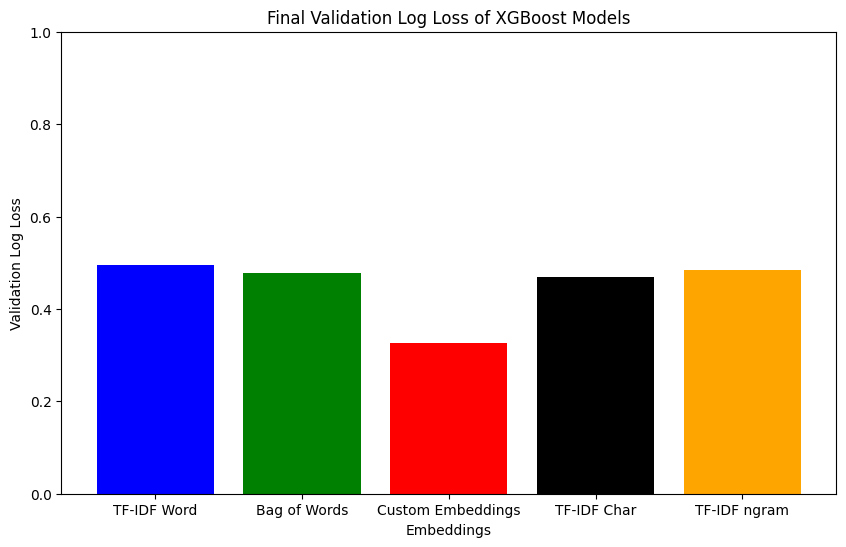

In [ ]:
import matplotlib.pyplot as plt


models = ['TF-IDF Word', 'Bag of Words', 'Custom Embeddings', 'TF-IDF Char', 'TF-IDF ngram']
accuracies = [0.49408566783432223, 0.47856332066775586, 0.3273114265075499,0.46981763319679787, 0.48349765260936056]  # Example accuracies

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red', 'black', 'orange'])
plt.xlabel('Embeddings')
plt.ylabel('Validation Log Loss')
plt.title('Final Validation Log Loss of XGBoost Models')
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
plt.show()

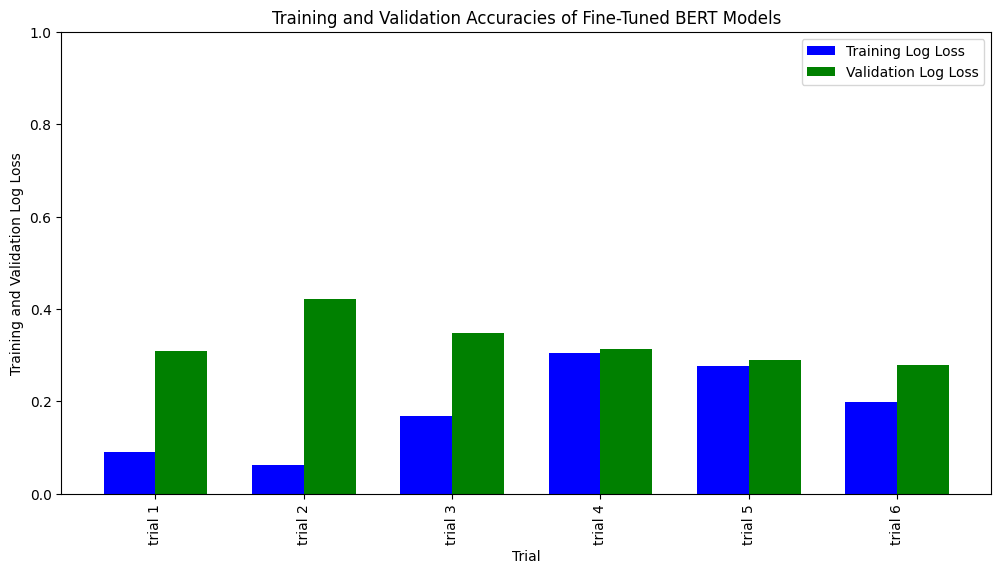

In [ ]:
training_accuracies = [.09, .0628, .168, .3048, .2759, .1995]
validation_accuracies = [.31, .4222, .349, .31287, .290721, .278074]

import numpy as np
import matplotlib.pyplot as plt
bar_width = 0.35
models = ['trial ' +str(i) for i in range(1,7)]
index = np.arange(len(models))
plt.figure(figsize=(12, 6))
bar1 = plt.bar(index, training_accuracies, bar_width, label='Training Log Loss', color='b')
bar2 = plt.bar(index + bar_width, validation_accuracies, bar_width, label='Validation Log Loss', color='g')

plt.xlabel('Trial')
plt.ylabel('Training and Validation Log Loss')
plt.title('Training and Validation Accuracies of Fine-Tuned BERT Models')
plt.xticks(index + bar_width / 2, models)
plt.xticks(rotation=90)
plt.legend()
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1

plt.show()